# Predicting Stock Movement with Company's Financial Data
## Phase 2: Data Pre-processing/ Predictive Modelling

####

#### From: Kit Wong

#### 

***
**DISCLAIMER:** Please do not assume this report is 100% accurate nor it fully satisfies all the project requirements for full credit.
***

## Table of Contents
* [Introduction](#itr) 
  + [Phase 1 Summary](#ph1-summary)
  + [Report Overview](#rpt-overview)
  + [Overview of Methodology](#overview-meth)
* [Data Pre-processing](#data-preprocess)  
* [Predictive Modelling](#pred-model)
  + [Binary vs Nominal Encoding](#binary-nominal)
   + [a) Performance with Full Set of Features with Binary Encoding)](#feature-selection-full-binary)
   + [b) Performance with Full Set of Features with Nominal Encoding](#feature-selection-full)
  + [Feature Selection](#feature-selection)
   + [a) Performance with Selective Features Using F-Score](#feature-selection-sel)
   + [b) Performance with Selective Features Using Random Forest Importance](#feature-selection-for)
   + [c) Performance with Selective Features Using Feature Selection Using spFSR](#feature-selection-fsr) 
   + [d) Performance Comparison Using Paired T-Tests](#feature-selection-comp) 
* [Model Fitting & Tuning](#model-fitting)
  + [a) Fitting a Nearest Neighbor Classifier](#knn)
  + [b) Fitting a Decision Tree Classifier](#dt)
  + [c) Fitting a Random Forests Classifier](#rf)
* [Neural Network Model Fitting & Tuning](#nn-model-fitting)  
* [Model Comparison](#model-ev)
* [Critique & Limitations](#critique-limit)
* [Summary and Conclusion](#Summary-and-Conclusion)
    + [Project Summary](#proj-summary)
    + [Summary of Findings](#summary-findings)
    + [Conclusions](#conclusions)
* [References](#References)



## Introduction <a id='itr'></a>

### Phase 1 Summary <a id='ph1-summary'></a>

The objective of this project is to predict stock movement with the company's Financial Data. The dataset used in this project is companies from the S&P 500 index.  The S&P 500 index contains 500 leading publicly traded companies in the United States that can provide a representative and diverse companies dataset. In phase 1, the target and descriptive features were identified from the dataset. Other than that, data cleaning has been performed with treatments for missing values.  Furthermore, data encoding was applied to prepare the multinomial targets and descriptive features for classification modeling in the later stage.  Last but not least, data exploration and visualization were performed to understand the data pattern and data relationship between the target features and the descriptive features.

### Report Overview <a id='rpt-overview'></a>

After going through the data exploration and visualization exercise in Phase 1, the target feature was found in a very imbalanced distribution that companies with a loss, a normal profit, and an outperformed profit represented 73%, 24%, and 2% accordingly.  The data distribution in the outperform profit category was too insignificant, the decision has been made to treat this category as an outliner to focus the data prediction on predicting companies with a normal profit or a loss return.  To do so, data with an outperformed profit will be removed from the data set.  3 binary classification predictive models will be performed and the dataset will use binary encoding instead of multinomial category encoding. Next, model tuning will be performed to select the optimal number of description features and optimal hyperparameter values for modeling. After that, an evaluation will be performed on the 3 binary classification model's results to select the best binary classification models for this dataset prediction.

### Overview of Methodology <a id='overview-meth'></a>

Phase 2 processes overview:
- Remove Outliner<br> 
Companies with returns above 100% have been considered outliers and will removed from modeling.  This step has been missed from the Phase 1 project.


- Binary vs Nominal Encoding Selection<br>
For descriptive features encoding, the binary encoding technique has been tried out to use pandas.get_dummies() function to translate each descriptive feature variable to an individual binary column. However, this method has created 670 binary descriptive columns.  Even though the binary encoding technique can produce a slightly better model accuracy (~4%), the project decided not to use this encoding method because the mass amount of descriptive features could make the model hard to understand.  Other than that, enforcing nomial descriptive features into binary format could produce bias in feature selection that this dataset experienced the top 10 best accuracy score binary values are from 2 descriptive features only.  Due to the aforementioned rationale and the nominal format of the descriptive features in this dataset, a nominal encoding technique has been employed.


- Feature Scaling<br>
The MinMaxScaler method was employed to normalize the dataset, ensuring that each descriptive feature falls within the range of 0 to 1.


- Machine Learning Models<br>
To achieve the goal of this project to use fundamental or economic data for stock return prediction, this problem has been structured as a classification machine learning problem. To do a comprehensive evaluation of the performance of various models, this project will perform modeling with 3 classification models and a Neural Network model. 
    - K Nearest Neighbor (KNN)
    - Decision Tree (DT)
    - Random Forest (RT)
    - Neural Network (NN)


- Feature Selection <br>
Feature selection can help improve the predictive accuracy, and speed up algorithm learning time. This project will use F-Score, Random Forest Feature, and spFSR feature importance score to select the 5 highest feature scores for modeling.


- Hyperparameter Tuning <br>
This project will use the grid search with accuracy scoring and stratified 5-fold cross-validation with a 3 repetitions approach for hyperparameter tuning. The grid search and stratified n-fold cross-validation was selected as the evaluation method because this method was suit for a small and imbalanced dataset like what we have in this project.


- Model Evaluation <br>
Model accuracy, precision, recall, f1, and roc auc score metrics will be used as metrics for performance comparison.

## Data Pre-processing <a id='data-preprocess'></a>

Dataset Retrieval

- Load the Phase 1 S&P 500 datasets from csv files
- Display 5 randomly sampled rows from the dataset to review the dataset and confirm successful loading

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn import feature_selection as fs
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, metrics

In [2]:
# Load Phase 1 Dataset 
df = pd.read_csv('Phase2_Group53.csv')
print('Dataset Shape: '+str(df.shape))
df.sample(5, random_state=999)

Dataset Shape: (501, 10)


,exchange,sector,industry,market_cap,ebitda,revenue_growth,state,country,full_time_employees,return_target
195,0,7,80,8486692864,7.097900e+08,0.042,26,0,297.0,n
417,1,2,6,17286782976,1.422800e+09,-0.096,4,0,9750.0,l
479,0,9,69,489284796416,3.886500e+10,0.057,36,0,2100000.0,n
280,1,9,49,44407328768,6.366000e+09,-0.071,7,0,36000.0,l
95,0,5,56,18925547520,1.831000e+09,0.094,13,0,12410.0,n


Data pre-processing steps:
- Remove outliners from the phase 1 dataset
- Split the dataset columns into `Data` and `target` dataframe.
- Normalize each descriptive feature with MinMaxScaler.

In [3]:
# Remove Outliner (return target = outperformed profit)
df = df[df.return_target != 'o']
print('Dataset Shape: '+str(df.shape))

Dataset Shape: (489, 10)


In [4]:
# Target feature encoding: normal profit = 0, loss = 1
target = df['return_target']
target = target.replace({"n":0, "l":1})
#target.value_counts()
print('Target Value Count: '+str(np.unique(target, return_counts = True)))

Target Value Count: (array([0, 1], dtype=int64), array([368, 121], dtype=int64))


In [5]:
Data = df.drop(columns = 'return_target').values

In [6]:
# Normalize each descriptive feature with MinMaxScaler
Data_scaler = preprocessing.MinMaxScaler()
Data = Data_scaler.fit_transform(Data)
Data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0404634 ],
       [0.        , 0.        , 0.00877193, ..., 0.02439024, 0.        ,
        0.00570103],
       [0.        , 0.1       , 0.01754386, ..., 0.04878049, 0.        ,
        0.0542731 ],
       ...,
       [0.33333333, 0.2       , 0.57017544, ..., 0.04878049, 0.        ,
        0.00462959],
       [0.        , 0.1       , 0.01754386, ..., 0.65853659, 0.        ,
        0.00855821],
       [0.        , 0.1       , 0.45614035, ..., 0.3902439 , 0.        ,
        0.00670104]])

## Predictive Modelling <a id='pred-model'></a>

### Binary vs Nominal Encoding <a id='binary-nominal'></a>

#### a) Performance with Full Set of Features with Binary Encoding <a id='feature-selection-full-binary'></a>
- Load un-encoded the dataset from phase 1
- Convert descriptive features into binary encoding.
- Use the decision tree classification model with default values
- Use stratified 5-fold cross-validation with 3 repetitions for performance assessment
- Perform the cross-validation using Accuracy scoring

In [7]:
scoring_metric = 'accuracy'

In [8]:
# Load the un-encoded dataset from Phase 1 (Reference:[2])
df_o = pd.read_csv('Phase2_Group53_0.csv', sep='\t')
df_o = df_o.iloc[: , 1:]  
df_o = df_o[df_o.return_target != 'o']
Data_o = df_o.drop(columns=['return_target'])
# Convert descriptive features into binary encoding
Data_encoded_o = pd.get_dummies(Data_o)
# Use the decision tree classifier with default values
clf = DecisionTreeClassifier(random_state=999)
# Use stratified 5-fold cross-validation with 3 repetitions for performance assessment
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                     n_repeats=3,
                                     random_state=999)
# Perform the cross-validation using Accuracy scoring
cv_results_full = cross_val_score(estimator=clf,
                             X=Data_encoded_o,     
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
print('Number of columns: '+str(len(Data_encoded_o.columns)))
print('DecisionTreeClassifier Accuracy score: '+str(cv_results_full.mean().round(3)))

Number of columns: 670
DecisionTreeClassifier Accuracy score: 0.731


In [9]:
# the 10 best accuracy features
num_features = 10
df_new = pd.DataFrame(Data_encoded_o, columns=Data_encoded_o.columns)
fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data_encoded_o, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]
best_features_fscore = df_new.columns[fs_indices_fscore].values
best_features_fscore

array(['sector_Utilities', 'industry_Utilities - Regulated Electric',
       'industry_Packaged Foods', 'sector_Consumer Defensive',
       'sector_Financial Services', 'sector_Industrials',
       'industry_Auto Parts', 'sector_Energy', 'industry_Solar',
       'industry_Utilities - Diversified'], dtype=object)

#### b) Performance with Full Set of Features with Nominal Encoding <a id='feature-selection-full'></a>
- Phase 1 dataset has been encoded with nominal encoding, encoding action was not required 
- Use the decision tree classification model with default values
- Use stratified 5-fold cross-validation with 3 repetitions for performance assessment
- Perform the cross-validation using Accuracy scoring<br><br>
Although the binary encoding technique produced a slightly better model accuracy, it produced 670 binary descriptive columns that make the model hard to understand. Other than that, the top 10 best accuracy score binary values are from 2 descriptive features only causing bias in feature selection.  The project decided to employ the nominal encoding technique.    

In [10]:
# Use the decision tree classifier with default values (Reference:[1])
clf = DecisionTreeClassifier(random_state=999)

In [11]:
# Use stratified 5-fold cross-validation with 3 repetitions for performance assessment (Reference:[1])
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                     n_repeats=3,
                                     random_state=999)

In [12]:
# Perform the cross-validation using Accuracy scoring (Reference:[1])
cv_results_full = cross_val_score(estimator=clf,
                             X=Data,
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)

In [13]:
print('DecisionTreeClassifier Accuracy score: '+str(cv_results_full.mean().round(3)))

DecisionTreeClassifier Accuracy score: 0.678


### Feature Selection <a id='feature-selection'></a>
- Look for 5 highest features using F-Score, Random Forest Feature, and spFSR feature importance score
- Use the 5 highest scored features to run the decision tree model
- Compare the model accuracy score with using the full set of descriptive features or other feature selection set
- Plot the 5 highest scored features based on feature importance score

#### a) Performance with Selective Features Using F-Score <a id='feature-selection-sel'></a>
The F-Score method combines the precision and recall of the model to provide a harmonic mean for the model. Using the the top 4 F-Score features to run the Decision Tree model, provided a higher accuracy score than using the full 10 description feature for modeling.

In [14]:
num_features = 5

In [15]:
# look for 4 highest F-Score features index positions (Reference:[1])
fs_fit_fscore = fs.SelectKBest(fs.f_classif, k=num_features)
fs_fit_fscore.fit_transform(Data, target)
fs_indices_fscore = np.argsort(np.nan_to_num(fs_fit_fscore.scores_))[::-1][0:num_features]
fs_indices_fscore

array([1, 3, 5, 0, 4], dtype=int64)

In [16]:
# the 4 highest F-Score features (Reference:[1])
best_features_fscore = df.columns[fs_indices_fscore].values
best_features_fscore

array(['sector', 'market_cap', 'revenue_growth', 'exchange', 'ebitda'],
      dtype=object)

In [17]:
# evaluate the performance of these features
cv_results_fscore = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_fscore],       
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
print('DecisionTreeClassifier Accuracy score (F-Score selected '+str(num_features)+' features): '
      +str(cv_results_fscore.mean().round(3)))

DecisionTreeClassifier Accuracy score (F-Score selected 5 features): 0.68


In [18]:
# ggplot function to plot the features's importance score (Reference:[1])
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

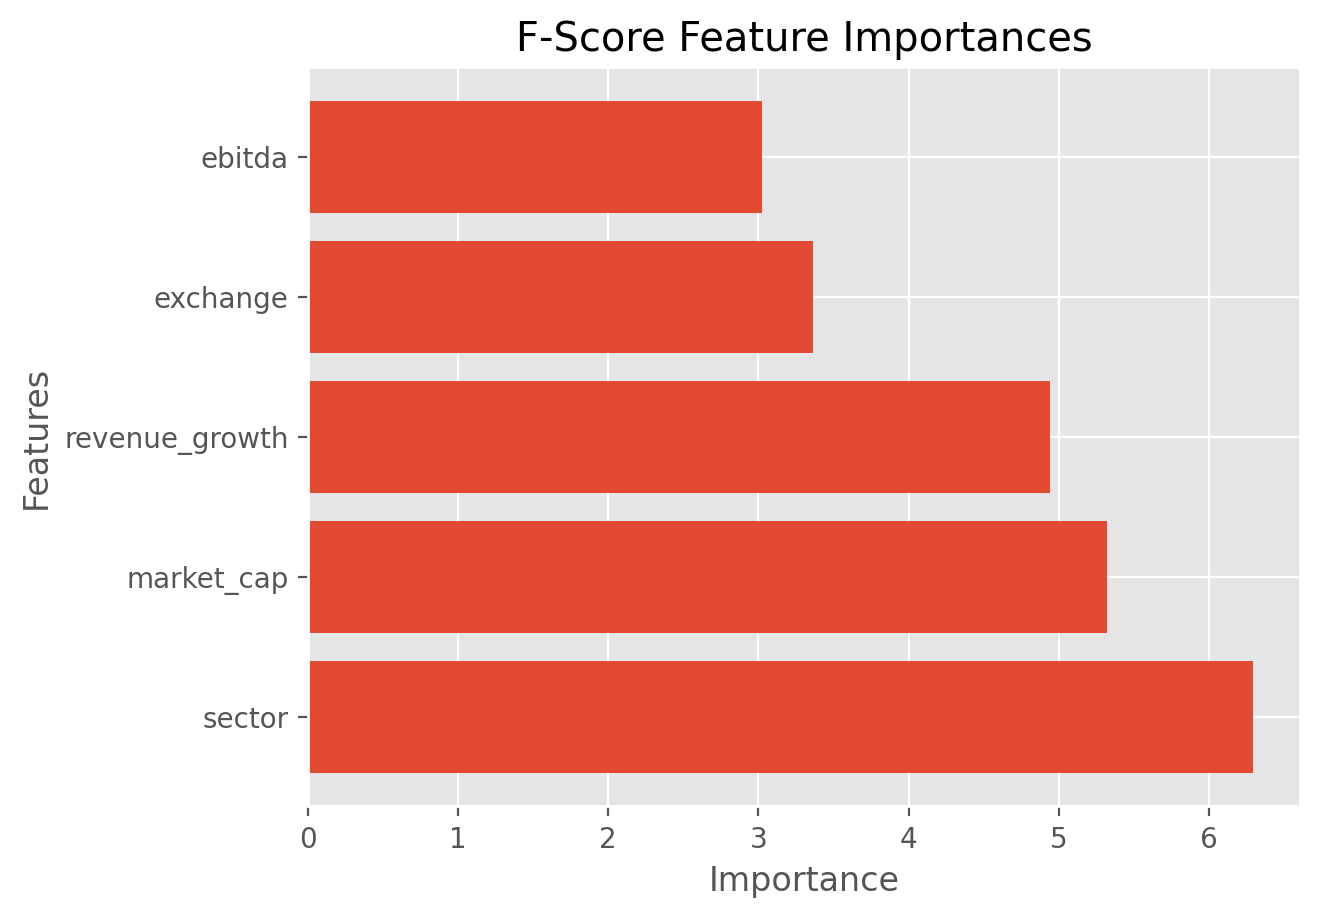

In [19]:
# Plot the 4 highest F-Score features based on F-Score
feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
plot_imp(best_features_fscore, feature_importances_fscore, 'F-Score')

#### b) Performance with Selective Features Using Random Forest Importance <a id='feature-selection-for'></a>
The Random Forest selected 2 similar and 2 different features from the F-Score feature selection result.  However, the Decision Tree model performance score from the 4 features using the Random Forest selection was lower when compared to the 4 features using the F-score selection.  Feature selection using the Random Forest feature importance score did not result in enhancing the performance of the model.

In [20]:
# look for 4 highest Random Forest importances score features (Reference:[1])
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

In [21]:
# the 4 highest Random Forest importances score features (Reference:[1])
best_features_rfi = df.columns[fs_indices_rfi].values
best_features_rfi

array(['revenue_growth', 'market_cap', 'full_time_employees', 'ebitda',
       'industry'], dtype=object)

In [22]:
# evaluate the performance of these features
cv_results_rfi = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_rfi],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)
print('DecisionTreeClassifier Accuracy score (RFI Importance Score selected '+str(num_features)+' features): '
      +str(cv_results_rfi.mean().round(3)))

DecisionTreeClassifier Accuracy score (RFI Importance Score selected 5 features): 0.665


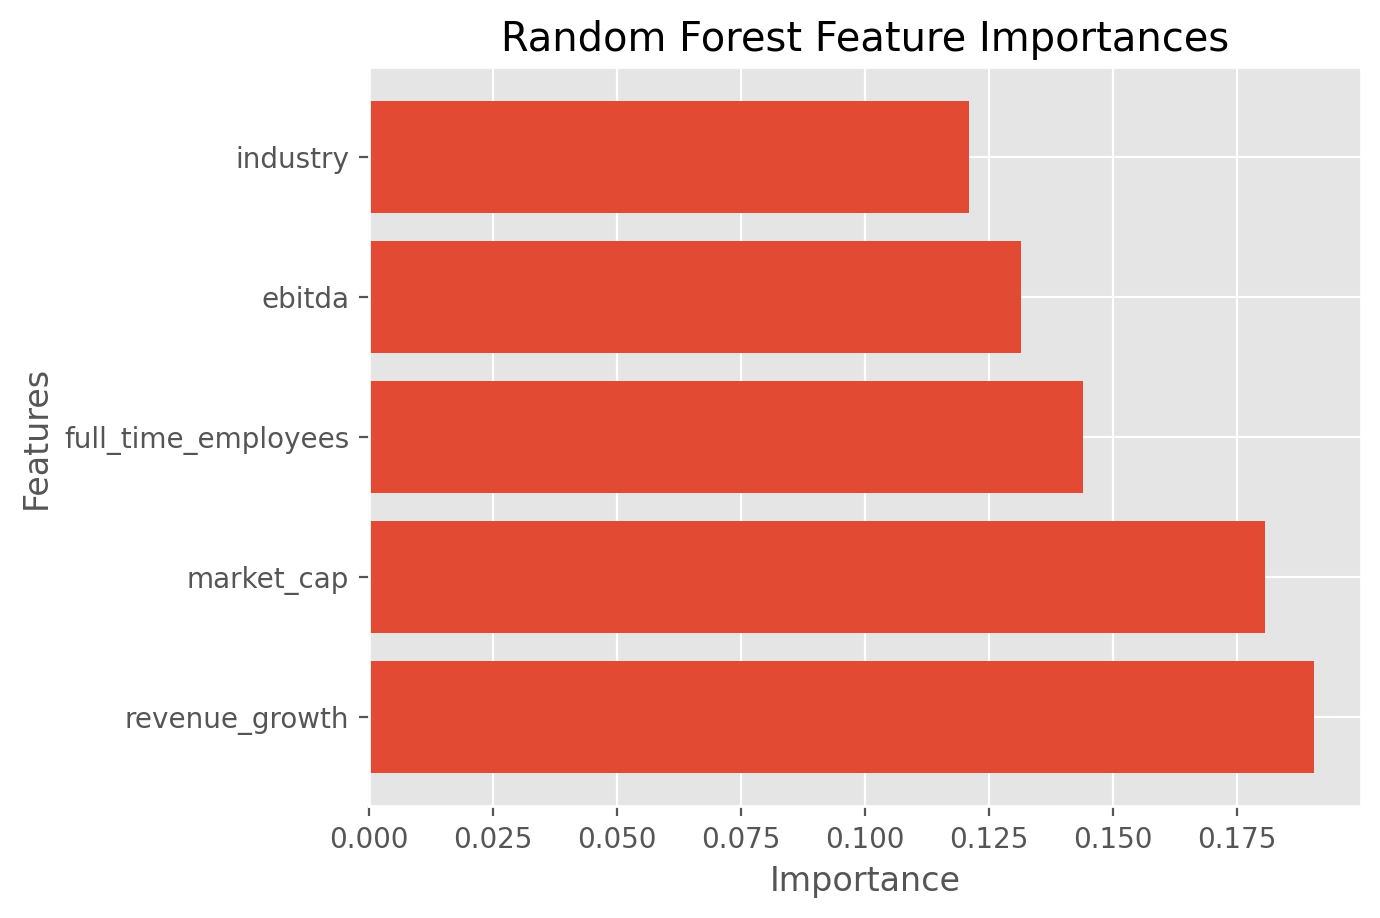

In [23]:
# Plot the 4 highest F-Score features based on RFI Importance Score
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest')

#### c) Performance with Selective Features Using Feature Selection Using spFSR <a id='feature-selection-fsr'>
Modeling using features selected from the spFSR yields the best predictive performance when compared to features selected by using the F-Score or Random Forest method.  The 4 most important features selected by spFSR are 'market_cap', 'industry', 'sector', and 'exchange'.  The spFSR employed a stochastic simultaneous algorithm and accuracy rate in feature selection.

In [24]:
from spFSR import SpFSR
# set the engine parameters, pred_type 'c' for classification
sp_engine = SpFSR(x=Data, y=target, pred_type='c', wrapper=clf, scoring='accuracy')
np.random.seed(999)
sp_output = sp_engine.run(num_features=num_features).results

SpFSR-INFO: Wrapper: DecisionTreeClassifier(random_state=999)
SpFSR-INFO: Hot start: True
SpFSR-INFO: Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 489
SpFSR-INFO: Number of observations used: 489
SpFSR-INFO: Number of features available: 9
SpFSR-INFO: Number of features to select: 5
SpFSR-INFO: iter_no: 0, num_ft: 5, value: 0.717, st_dev: 0.058, best: 0.717 @ iter_no 0
SpFSR-INFO: ===> iter_no: 9, same feature stall limit reached, initializing search...
SpFSR-INFO: iter_no: 10, num_ft: 5, value: 0.693, st_dev: 0.04, best: 0.717 @ iter_no 0
SpFSR-INFO: iter_no: 20, num_ft: 5, value: 0.677, st_dev: 0.048, best: 0.717 @ iter_no 0
SpFSR-INFO: ===> iter_no: 22, same feature stall limit reached, initializing search...
SpFSR-INFO: ===> iter_no: 26, same feature stall limit reached, initializing search...
SpFSR-INFO: iter_no: 30, num_ft: 5, value: 0.662, st_dev: 0.

In [25]:
fs_indices_spfsr = sp_output.get('selected_features')
best_features_spfsr = df.columns[fs_indices_spfsr]
best_features_spfsr

Index(['market_cap', 'revenue_growth', 'ebitda', 'industry', 'sector'], dtype='object')

In [26]:
cv_results_spfsr = cross_val_score(estimator=clf,
                             X=Data[:, fs_indices_spfsr],
                             y=target, 
                             cv=cv_method, 
                             scoring=scoring_metric)

print('DecisionTreeClassifier Accuracy score (spfsr Importance Score selected '+str(num_features)+' features): '
      +str(cv_results_spfsr.mean().round(3)))

DecisionTreeClassifier Accuracy score (spfsr Importance Score selected 5 features): 0.701


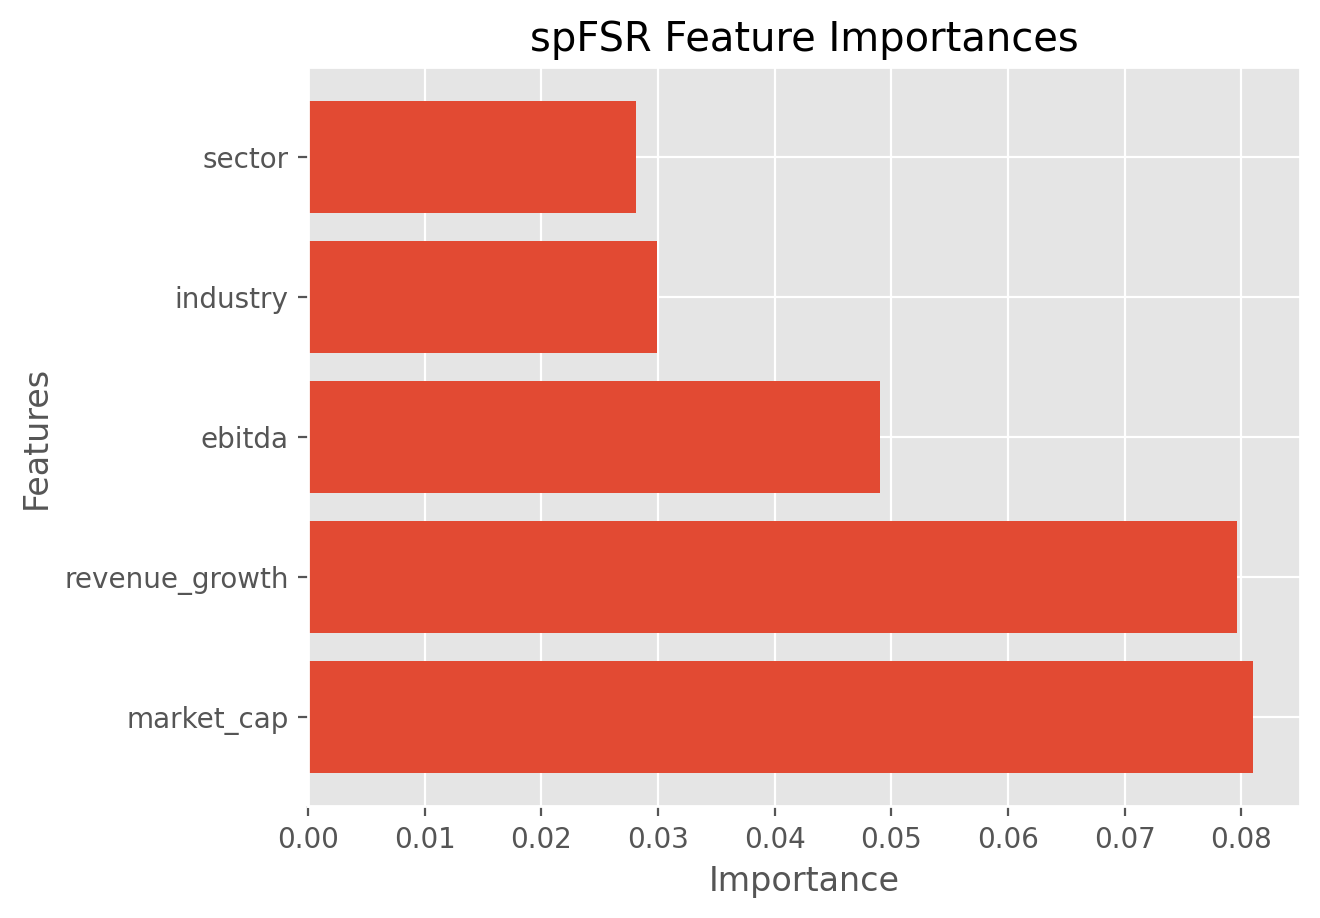

In [27]:
feature_importances_spfsr = sp_output.get('selected_ft_importance')
plot_imp(best_features_spfsr, feature_importances_spfsr, 'spFSR')

#### d) Performance Comparison Using Paired T-Tests <a id='feature-selection-comp'>
According to the model performance, features selected by the spFSR are outperformed by using the full set of features or features selected by F-Score or FRI.  To check if the above observation is statistically significant, a paired t-test with using Python stats.ttest_rel function from the scipy module was performed.  At a 95% significance level, if the p-value is smaller than 0.05, it can be concluded that the difference is statistically significant. (Reference: [1])

In [28]:
Data[:, fs_indices_spfsr]

array([[0.0166178 , 0.26186131, 0.08247667, 0.        , 0.        ],
       [0.00230338, 0.29105839, 0.03185355, 0.00877193, 0.        ],
       [0.0611225 , 0.27235401, 0.10108399, 0.01754386, 0.1       ],
       ...,
       [0.00304076, 0.11541971, 0.03143575, 0.57017544, 0.2       ],
       [0.00682408, 0.29425182, 0.04355276, 0.01754386, 0.1       ],
       [0.02280817, 0.30428832, 0.0510122 , 0.45614035, 0.1       ]])

In [29]:
#Performance Comparison Using Paired T-Tests
print('Full Set of Features:', cv_results_full.mean().round(3))
print('F-Score:', cv_results_fscore.mean().round(3))
print('RFI:', cv_results_rfi.mean().round(3))
print('spFSR:', cv_results_spfsr.mean().round(3)) 

Full Set of Features: 0.678
F-Score: 0.68
RFI: 0.665
spFSR: 0.701


In [30]:
from scipy import stats
print('Paired t-test of spfsr vs. Full set of features, p-value: '+str(stats.ttest_rel(cv_results_spfsr, cv_results_full).pvalue.round(3)))
print('Paired t-test of spfsr vs. F-Score, p-value: '+str(stats.ttest_rel(cv_results_spfsr, cv_results_fscore).pvalue.round(3)))
print('Paired t-test of spfsr vs. RFI, p-value: '+str(stats.ttest_rel(cv_results_spfsr, cv_results_rfi).pvalue.round(3)))

Paired t-test of spfsr vs. Full set of features, p-value: 0.132
Paired t-test of spfsr vs. F-Score, p-value: 0.186
Paired t-test of spfsr vs. RFI, p-value: 0.014


The p-values for spfsr vs. RFI is below 0.05, it can be concluded that spfsr is statistically better than the RFI methods. However, the p-values for spfsr to the full set of features or F-Score are above 0.05, thus spfsr with 5 features performs statistically the same as the full set of features or with the 5 features selected by the F-Score for the decision tree classifier.  

Compared with various selective features' performance, the project decided to use features selected from spfsr because it outperformed by using the full set of features or features selected by F-Score or FRI. The feature selected by spfsr are 'sector', 'industry', 'ebitda', 'revenue_growth', 'market_cap'.

### Model Fitting & Tuning <a id='model-fitting'></a>

The dataset was divided into 70% for training and 30% for testing purposes. The project conducted experiments with four classification models: K Nearest Neighbor (KNN), Decision Tree (DT), Random Forest (RF), and Neural Network (NN). Additionally, hyperparameter tuning was conducted to identify the most suitable hyperparameter values for each model.

In [31]:
# Spliting Data into Training and Test Sets
D_train, D_test, t_train, t_test = \
    train_test_split(Data[:, fs_indices_spfsr], target, test_size = 0.3, 
                     stratify=target, shuffle=True, random_state=999)

### a) Fitting a Nearest Neighbor Classifier <a id='knn'></a>

The K nearest neighbor classifier was started by fitting with 1 neighbor (n_neighbors=1) and using the Euclidean distance (p=2). The 1-nearest neighbor (1-NN) accuracy score is around 73.5%.  To improve the accuracy score, the grid search and stratified 5-fold cross-validation approach were performed for hyperparameter tuning.

In [32]:
# Fitting a nearest neighbor classifier with 1 neighbors using the Euclidean distance (p=2)
knn_classifier = KNeighborsClassifier(n_neighbors=1, p=2)
knn_classifier.fit(D_train, t_train);
knn_classifier.score(X=D_test, y=t_test)

0.7346938775510204

This project used a stratified 5-flod cross-validation to partition the dataset into 5 equal-sized chunks that 4 chunks of data was used for training and 1 chuck of data used for testing.  Model fitting was set to repeat 3 times to produce a averaged result to estimated the model's performance.  The Stratified K-fold cross-validation was selected as the evaluation method because this method was suit for a small and imbalanced dataset like what we have in this project.


In [33]:
# conduct a 5-fold (n_splits = 5) cross-validation with 3 repetitions (n_repeats = 3) (Reference:[5])
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [34]:
# define K values between 3 and 7, and  𝑝 values of 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski). (Reference:[5])
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 5]}

In [35]:
# use GridSearchCV function to performs hyperparameter tuning with the defined option from params_KNN (Reference:[5])
gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='accuracy', 
                      return_train_score=True)
gs_KNN.fit(D_train, t_train);
gs_KNN.best_params_

Fitting 15 folds for each of 21 candidates, totalling 315 fits


{'n_neighbors': 2, 'p': 1}

In [36]:
# parameter with the best accuracy score
gs_KNN.best_score_

0.7797811878374539

In [37]:
# summary of the grid search repeated stratified KFold hyperparameter tuning results 
results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
results_KNN

,n_neighbors,p,test_score,metric
0,1,1,0.716468,Manhattan
1,1,2,0.713484,Euclidean
2,1,5,0.707701,Minkowski
3,2,1,0.779781,Manhattan
4,2,2,0.773927,Euclidean
5,2,5,0.769054,Minkowski
6,3,1,0.758383,Manhattan
7,3,2,0.751520,Euclidean
8,3,5,0.743691,Minkowski
9,4,1,0.762305,Manhattan


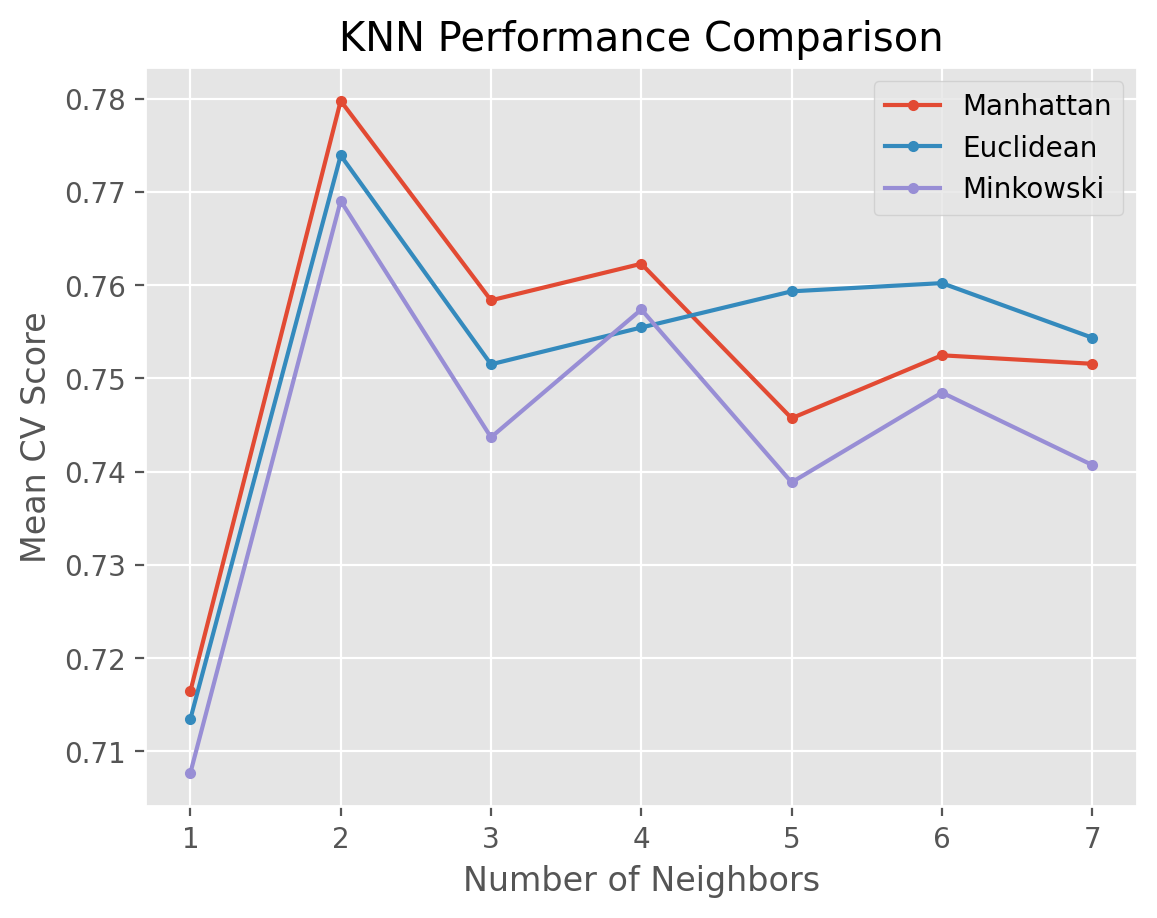

In [38]:
# visualize the grid search repeated stratified KFold hyperparameter tuning results 
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], marker = '.', label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel("Mean CV Score")
plt.title("KNN Performance Comparison")
plt.show()

From the grid search stratified 5-fold cross-validation, the nearest neighbor classifier achieved the best score (0.7671) with 3 neighbor (n_neighbors=3) and using the Euclidean distance (p=2).  The hyperparameter tuning result with different hyperparameter settings can be found in the above datafram and the performance Comparison plot. Applying the optimal hyperparameter to the K nearest neighbor classifier, the model accuracy score of around 78.9% was achieved.	

In [39]:
# Fitting a nearest neighbor classifier with 3 neighbors using the Euclidean distance (p=2)
knn_classifier = KNeighborsClassifier(n_neighbors=3, p=2)
knn_classifier.fit(D_train, t_train);
knn_classifier.score(X=D_test, y=t_test)

0.7891156462585034

The confusion matrix showed prediction with True Negative (TN) = 95, False Positive (FP) = 16, False Negative (FN)	= 15, True Positive (TP) = 21

In [40]:
# get the predictions for the test data using the best estimator (Reference:[7])
t_pred_knn = knn_classifier.predict(D_test)
metrics.confusion_matrix(t_test, t_pred_knn)

array([[95, 16],
       [15, 21]], dtype=int64)

The K nearest neighbor model performance showed profit return target has higher precision, recall, and f1-socre than the loss return target.  The overall accuracy score is 78.9% with the weighted average precision, recall, and f1-score at all around 79%.

In [41]:
# Model Performance (Target feature encoding: normal profit = 0, loss = 1) (Reference:[7])
print(metrics.classification_report(t_test, t_pred_knn))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       111
           1       0.57      0.58      0.58        36

    accuracy                           0.79       147
   macro avg       0.72      0.72      0.72       147
weighted avg       0.79      0.79      0.79       147



Performance calculation metrics micro averaging was recorded because it does not distinguish between classes is more preferred for an imbalanced dataset.

In [42]:
# log model performance
dict_result = { 'model':"K Nearest Neighbor",
                'accuracy':round(metrics.accuracy_score(t_test, t_pred_knn),2),
                'err_rate':round(1 - metrics.accuracy_score(t_test, t_pred_knn),2),                
                'precision':round(metrics.precision_score(t_test, t_pred_knn, average='micro'),2),
                'recall':round(metrics.recall_score(t_test, t_pred_knn, average='micro'),2),
                'f1':round(metrics.f1_score(t_test, t_pred_knn, average='micro'),2),
                'roc_auc':round(metrics.roc_auc_score(t_test, t_pred_knn, average='micro'),2)
               }
df_result = pd.DataFrame(dict_result, index=[0])

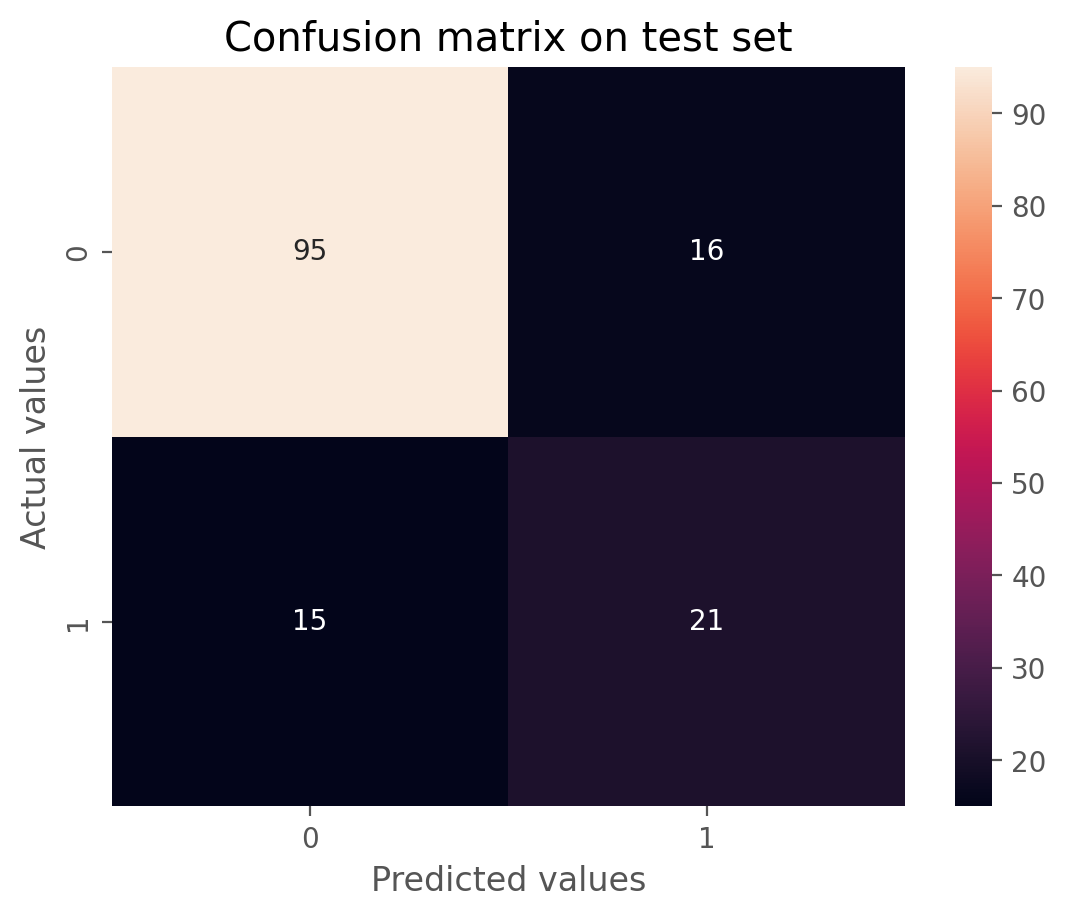

In [43]:
# confusion matrix  heatmap (Reference:[7])
cf_matrix = metrics.confusion_matrix(t_test, t_pred_knn)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
ax.set(xlabel='Predicted values', ylabel='Actual values')
ax.set_title("Confusion matrix on test set")
plt.show()

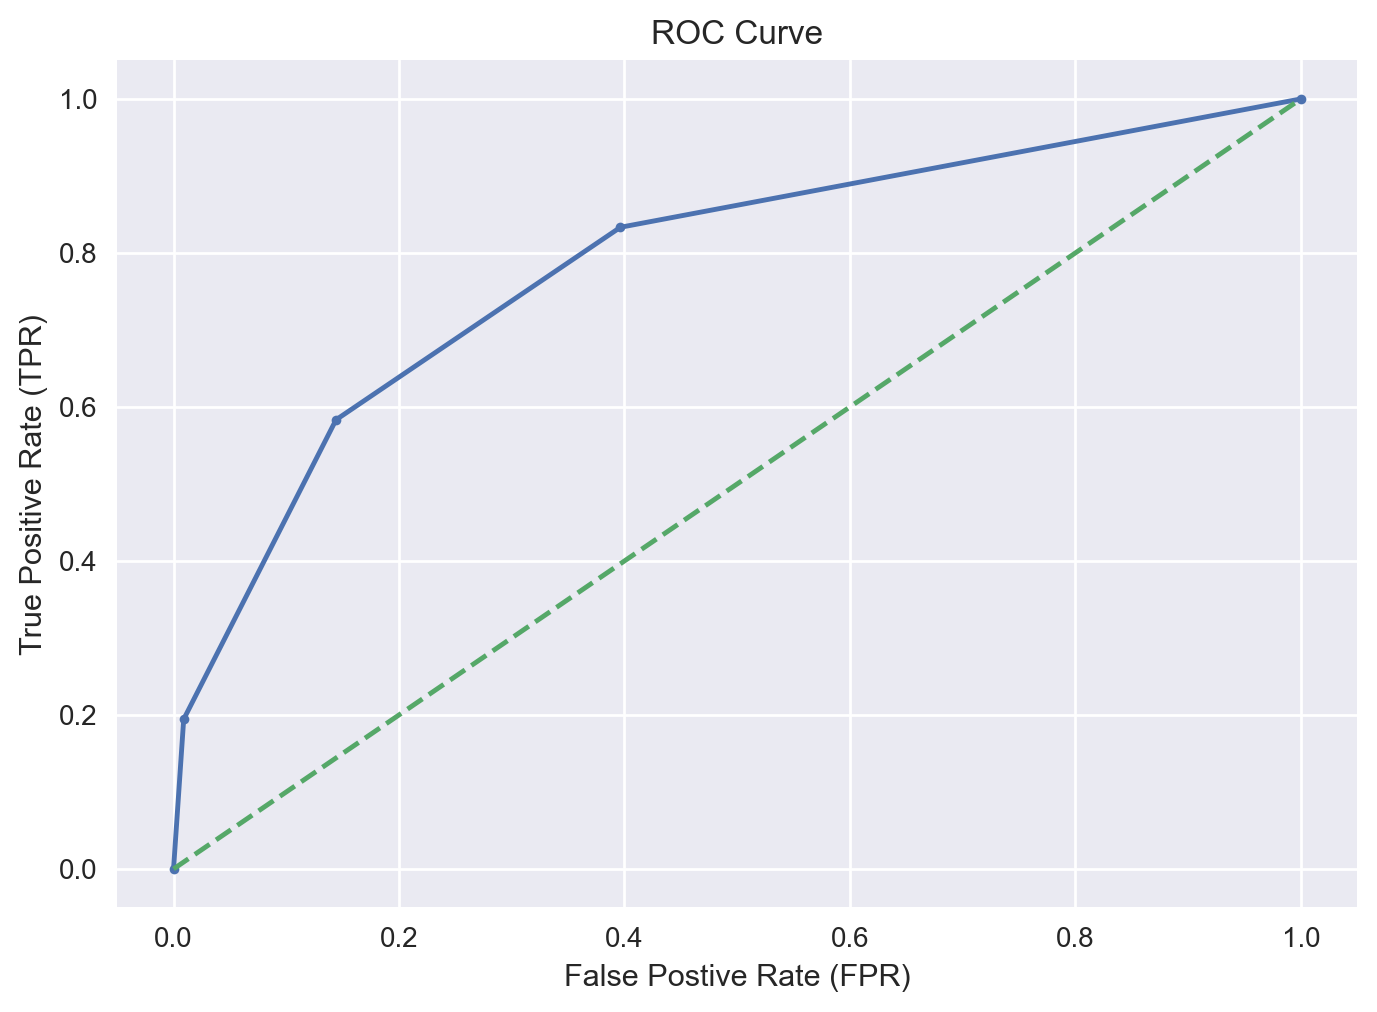

In [44]:
# ROC curve by calculating prediction scores using the predict_proba method in Scikit-learn (Reference:[7])
t_prob_knn = knn_classifier.predict_proba(D_test)
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_knn[:, 1])
df_roc_knn = pd.DataFrame({'fpr': fpr, 'tpr': tpr})

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")
    
ax = df_roc_knn.plot.line(x='fpr', y='tpr', title='ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show();

The ROC curve has an "elbow" between FNR 0.2 and 0.4 with a high corresponding TPR. This indicates the optimized KNN model has a good predictive performance.

### b) Fitting a Decision Tree Classifier <a id='dt'></a>
The Decision Tree classifier was started by fitting with 1 levels of maximum depth (max_depth=1) and entropy as the criterion (criterion='entropy'). These parameter settings produce an accuracy score of around 74.8%.  To improve the accuracy score, the grid search and stratified 5-fold cross-validation approach were performed for hyperparameter tuning.

In [45]:
# Fitting a decision tree classifier with 1 max depth using the entropy criterion
dt_classifier = DecisionTreeClassifier(max_depth=1,
                                       criterion='entropy',
                                       random_state = 999)
dt_classifier.fit(D_train, t_train);
dt_classifier.score(D_test, t_test)

0.7482993197278912

In [46]:
# use GridSearchCV function to performs hyperparameter tuning with the defined option from params_DT (Reference:[5])
df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     verbose=1, 
                    scoring='accuracy')

gs_DT.fit(Data, target);
gs_DT.best_params_

Fitting 15 folds for each of 32 candidates, totalling 480 fits


{'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}

In [47]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT

,criterion,max_depth,min_samples_split,test_score
0,gini,1,2,0.733495
1,gini,1,3,0.733495
2,gini,2,2,0.731461
3,gini,2,3,0.731461
4,gini,3,2,0.729448
5,gini,3,3,0.729448
6,gini,4,2,0.732190
7,gini,4,3,0.732190
8,gini,5,2,0.713100
9,gini,5,3,0.713100


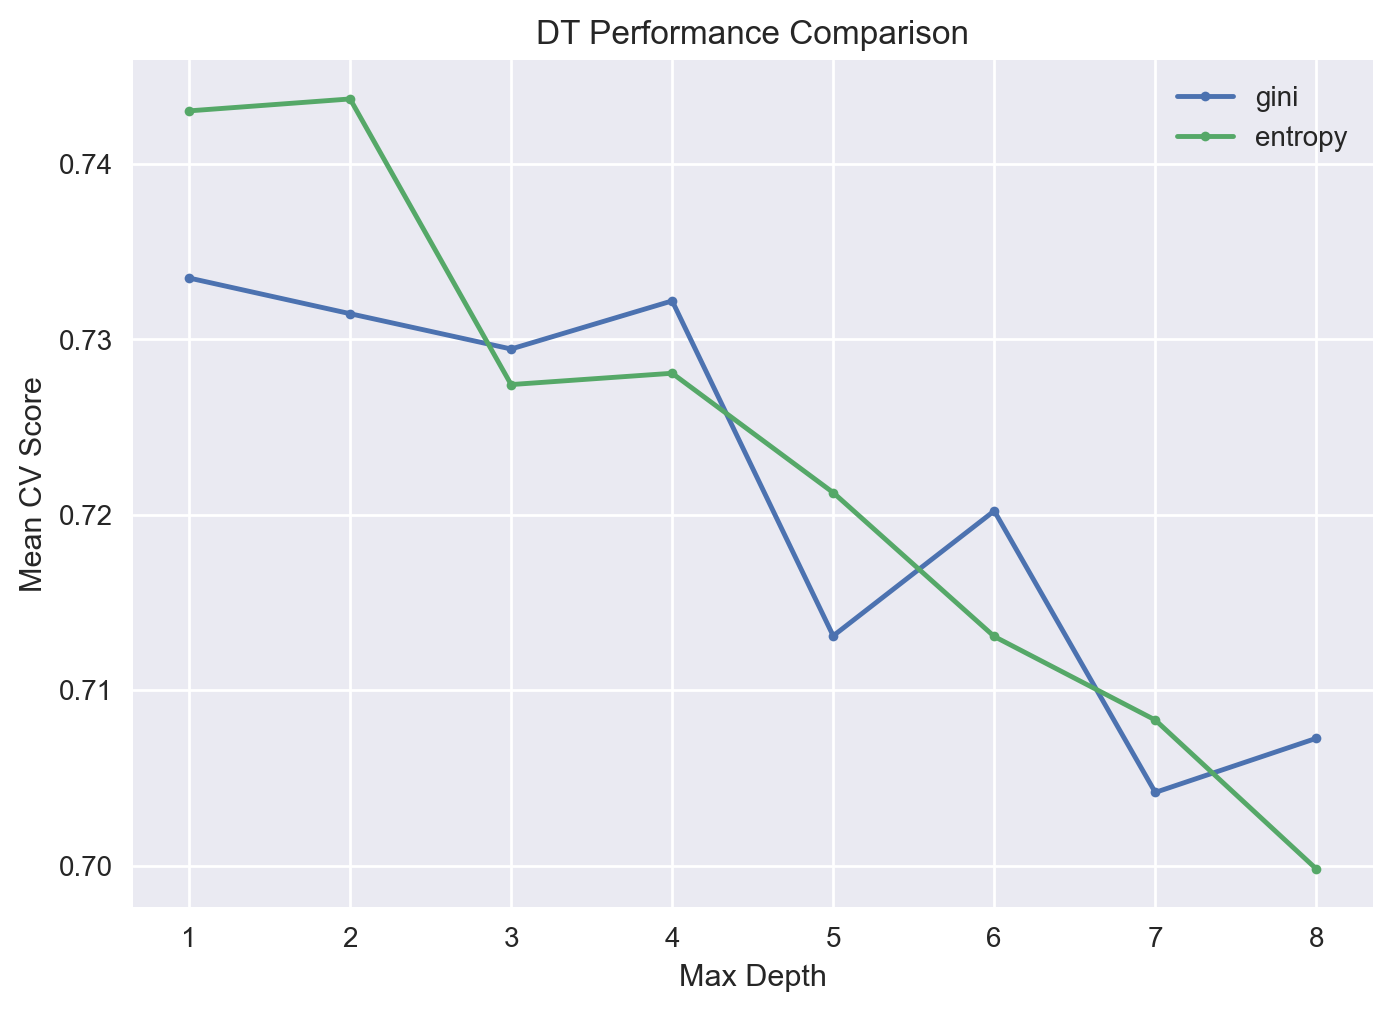

In [48]:
# visualize the grid search repeated stratified Decision Tree hyperparameter tuning results 
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

From the grid search stratified 5-fold cross-validation, the decision tree classifier achieved the best score (0.755) with 2 levels of max depth (max_depth=2), 2 minimum sample split (min_samples_split=2), and using the entropy criterion (criterion=entropy). The hyperparameter tuning result with different hyperparameter settings can be found in the above datafram and the performance Comparison plot. Applying the optimal hyperparameter to the decision tree classifier, the model accuracy score of around 0.755 was achieved.

In [49]:
# Fitting a decision tree classifier with 2 max depth using the entropy criterion
dt_classifier = DecisionTreeClassifier(max_depth=2,
                                       criterion='entropy',
                                       min_samples_split=2,
                                       random_state = 999)
dt_classifier.fit(D_train, t_train);
dt_classifier.score(D_test, t_test)

0.7551020408163265

The confusion matrix showed prediction with True Negative (TN) = 110, False Positive (FP) = 1, False Negative (FN)	= 35, True Positive (TP) = 1

In [50]:
# get the predictions for the test data using the best estimator (Reference:[7])
t_pred_dt = dt_classifier.predict(D_test)
metrics.confusion_matrix(t_test, t_pred_dt)

array([[110,   1],
       [ 35,   1]], dtype=int64)

The decision tree model performance showed profit return target has higher precision, recall, and f1-socre than the loss return target.  The overall accuracy score is 75.5% with the weighted average precision, recall, and f1-score at around 70%, 76%, and 66% respectively.

In [51]:
# Model Performance (Target feature encoding: normal profit = 0, loss = 1) (Reference:[7])
print(metrics.classification_report(t_test, t_pred_dt))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86       111
           1       0.50      0.03      0.05        36

    accuracy                           0.76       147
   macro avg       0.63      0.51      0.46       147
weighted avg       0.70      0.76      0.66       147



Performance calculation metrics micro averaging was recorded because it does not distinguish between classes is more preferred for an imbalanced dataset.

In [52]:
# log model performance
dict_result = { 'model':'Decision Tree',
                'accuracy':round(metrics.accuracy_score(t_test, t_pred_dt),2),
                'err_rate':round(1 - metrics.accuracy_score(t_test, t_pred_dt),2),                
                'precision':round(metrics.precision_score(t_test, t_pred_dt, average='micro'),2),
                'recall':round(metrics.recall_score(t_test, t_pred_dt, average='micro'),2),
                'f1':round(metrics.f1_score(t_test, t_pred_dt, average='micro'),2),
                'roc_auc':round(metrics.roc_auc_score(t_test, t_pred_dt, average='micro'),2)
               }
df_result = df_result.append(dict_result, ignore_index=True)

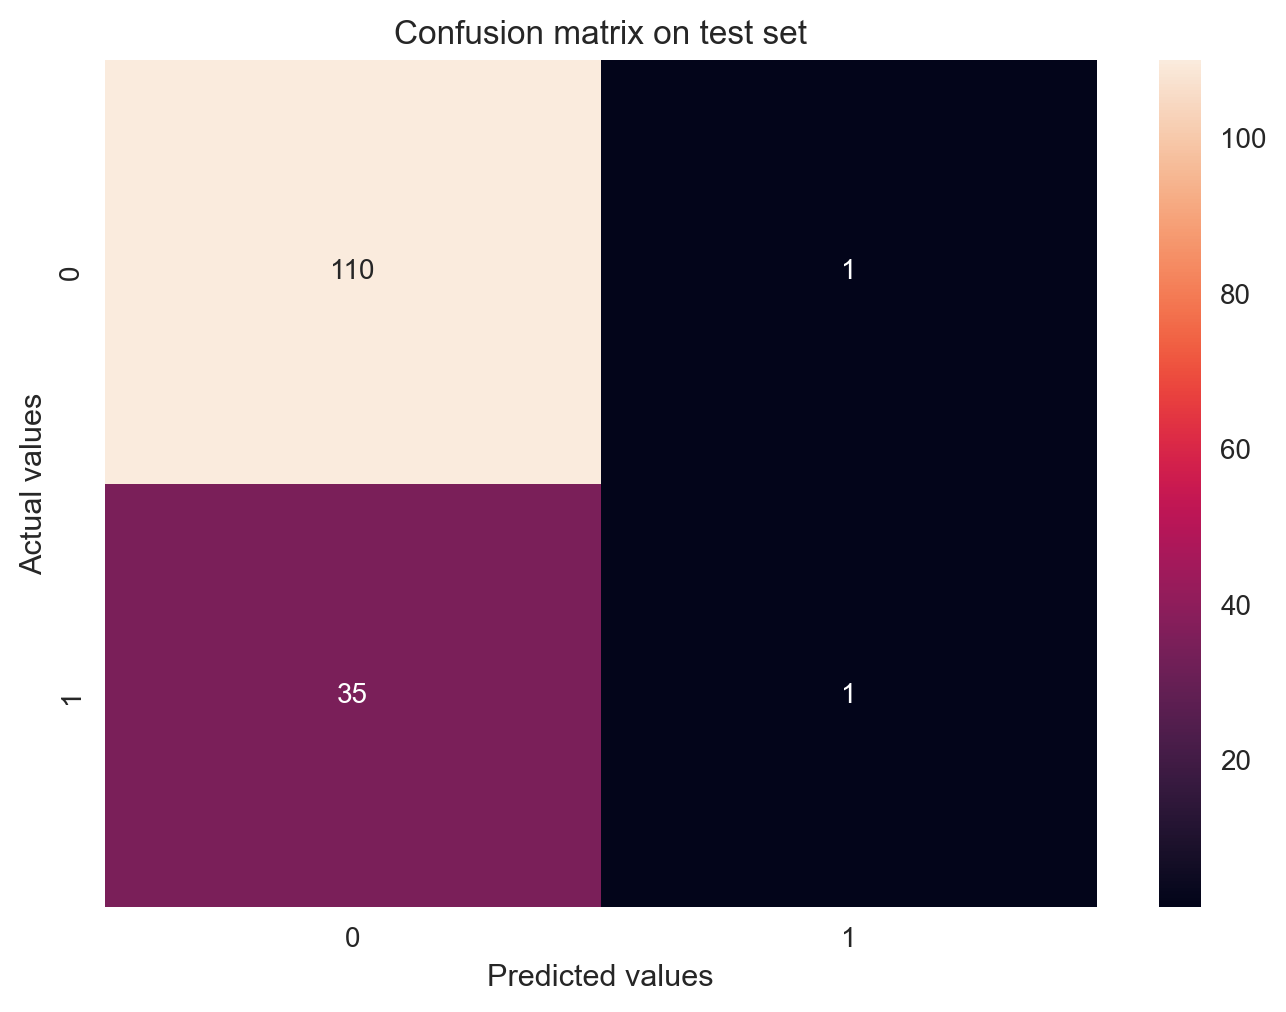

In [53]:
# confusion matrix  heatmap (Reference:[7])
cf_matrix = metrics.confusion_matrix(t_test, t_pred_dt)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
ax.set(xlabel='Predicted values', ylabel='Actual values')
ax.set_title("Confusion matrix on test set")
plt.show()

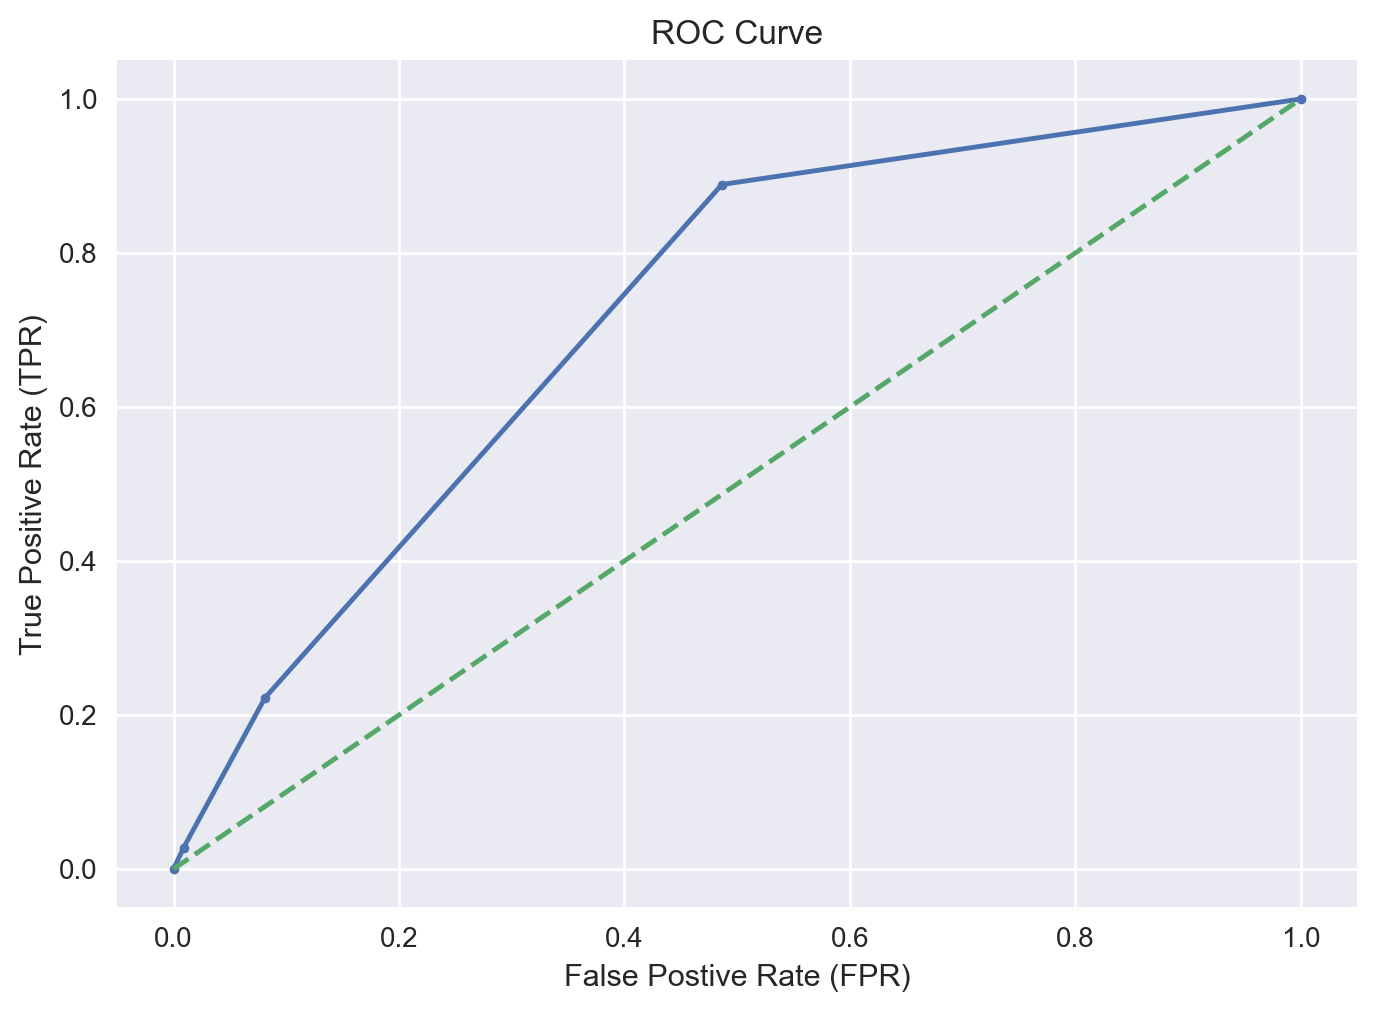

In [54]:
# ROC curve by calculating prediction scores using the predict_proba method in Scikit-learn (Reference:[7])
t_prob_dt = dt_classifier.predict_proba(D_test)
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_dt[:, 1])
df_roc_dt = pd.DataFrame({'fpr': fpr, 'tpr': tpr})

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")
    
ax = df_roc_dt.plot.line(x='fpr', y='tpr', title='ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show();

The ROC curve has an "elbow" between FNR 0.5 with a high corresponding TPR. This indicates the optimized KNN model has a good predictive performance.

### c) Fitting a Random Forests Classifier <a id='rf'></a>
The Random Forests classifier was started by fitting with 100 estimators (n_estimators=1) and gini as the criterion (criterion='gini'). These parameter settings produce an accuracy score of around 78.2%. To improve the accuracy score, the grid search and stratified 5-fold cross-validation approach were performed for hyperparameter tuning.

In [55]:
# Fitting a random forest classifier with 100 n estimator using the defult gini criterion
rf_classifier = RandomForestClassifier(n_estimators=100, 
                                       criterion='gini',
                                       random_state=999)
rf_classifier.fit(D_train, t_train)
rf_classifier.score(X=D_test, y=t_test)

0.782312925170068

In [56]:
# use GridSearchCV function to performs hyperparameter tuning with the defined option from params_RF (Reference:[5])
rf_classifier = RandomForestClassifier(random_state=999)

params_RF = {'criterion': ['gini', 'entropy'],
             'max_features': ['sqrt', 'log2'],
             'n_estimators': [100, 150, 200, 250, 300]
            }

gs_RF = GridSearchCV(estimator=rf_classifier, 
                     param_grid=params_RF, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

gs_RF.fit(Data, target);
gs_RF.best_params_

Fitting 15 folds for each of 20 candidates, totalling 300 fits


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

In [57]:
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']
results_RF

,criterion,max_features,n_estimators,test_score
0,gini,sqrt,100,0.760755
1,gini,sqrt,150,0.758707
2,gini,sqrt,200,0.759394
3,gini,sqrt,250,0.755979
4,gini,sqrt,300,0.757339
5,gini,log2,100,0.760755
6,gini,log2,150,0.758707
7,gini,log2,200,0.759394
8,gini,log2,250,0.755979
9,gini,log2,300,0.757339


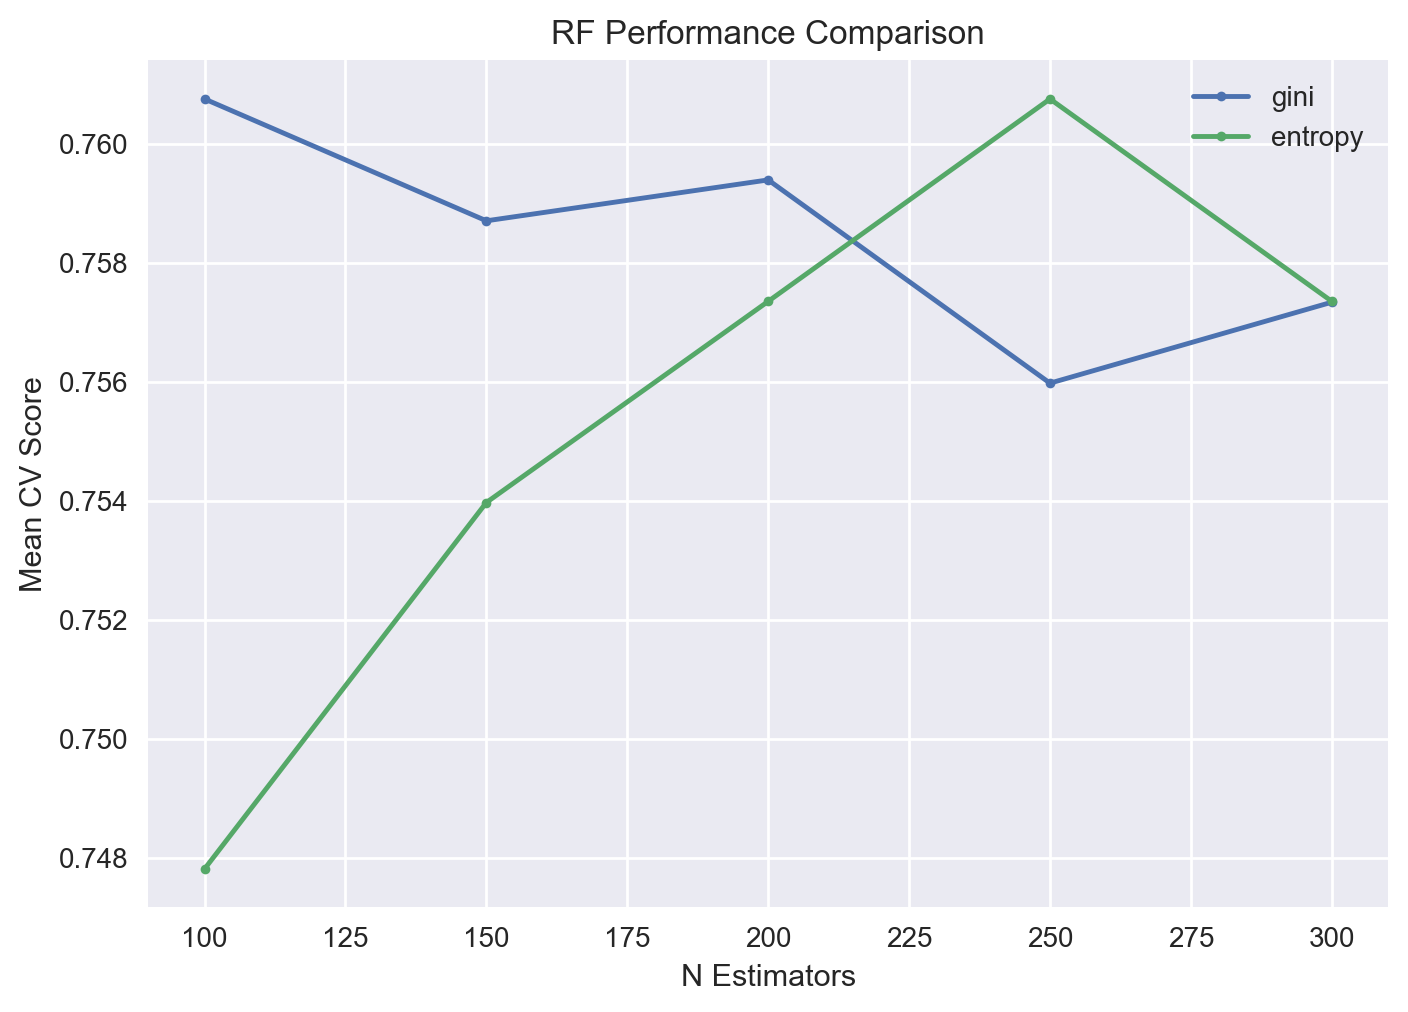

In [58]:
# visualize the grid search repeated stratified Decision Tree hyperparameter tuning results (Reference:[5])
for i in ['gini', 'entropy']:
    temp = results_RF[results_RF['criterion'] == i]
    temp_average = temp.groupby('n_estimators').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('N Estimators')
plt.ylabel("Mean CV Score")
plt.title("RF Performance Comparison")
plt.show()

From the grid search stratified 5-fold cross-validation, the random forests classifier achieved the best score (0.762) with 250 estimators (n_estimators=250), sqrt as the max features split (max_features = 'sqrt'), and using the entropy criterion (criterion=entropy). The hyperparameter tuning result with different hyperparameter settings can be found in the above datafram and the performance Comparison plot. Applying the optimal hyperparameter to the random forests classifier, the model accuracy score of around 78.2% was achieved.

In [59]:
rf_classifier = RandomForestClassifier(n_estimators=250, 
                                       criterion='entropy',
                                       max_features = 'sqrt',
                                       random_state = 999)
rf_classifier.fit(D_train, t_train)
rf_classifier.score(X=D_test, y=t_test)

0.782312925170068

The confusion matrix showed prediction with True Negative (TN) = 104, False Positive (FP) = 7, False Negative (FN)	= 25, True Positive (TP) = 11

In [60]:
# get the predictions for the test data using the best estimator (Reference:[7])
t_pred_rf = rf_classifier.predict(D_test)
metrics.confusion_matrix(t_test, t_pred_rf)

array([[104,   7],
       [ 25,  11]], dtype=int64)

The random forest model performance showed profit return target has higher precision, recall, and f1-socre than the loss return target.  The overall accuracy score is 75.5% with the weighted average precision, recall, and f1-score at around 75%-78%.

In [61]:
# Model Performance (Target feature encoding: normal profit = 0, loss = 1) (Reference:[7])
print(metrics.classification_report(t_test, t_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       111
           1       0.61      0.31      0.41        36

    accuracy                           0.78       147
   macro avg       0.71      0.62      0.64       147
weighted avg       0.76      0.78      0.75       147



Performance calculation metrics micro averaging was recorded because it does not distinguish between classes is more preferred for an imbalanced dataset.

In [62]:
# log model performance
dict_result = { 'model':'Random Forest',
                'accuracy':round(metrics.accuracy_score(t_test, t_pred_rf),2),
                'err_rate':round(1 - metrics.accuracy_score(t_test, t_pred_rf),2),                
                'precision':round(metrics.precision_score(t_test, t_pred_rf, average='micro'),2),
                'recall':round(metrics.recall_score(t_test, t_pred_rf, average='micro'),2),
                'f1':round(metrics.f1_score(t_test, t_pred_rf, average='micro'),2),
                'roc_auc':round(metrics.roc_auc_score(t_test, t_pred_rf, average='micro'),2)
               }
df_result = df_result.append(dict_result, ignore_index=True)

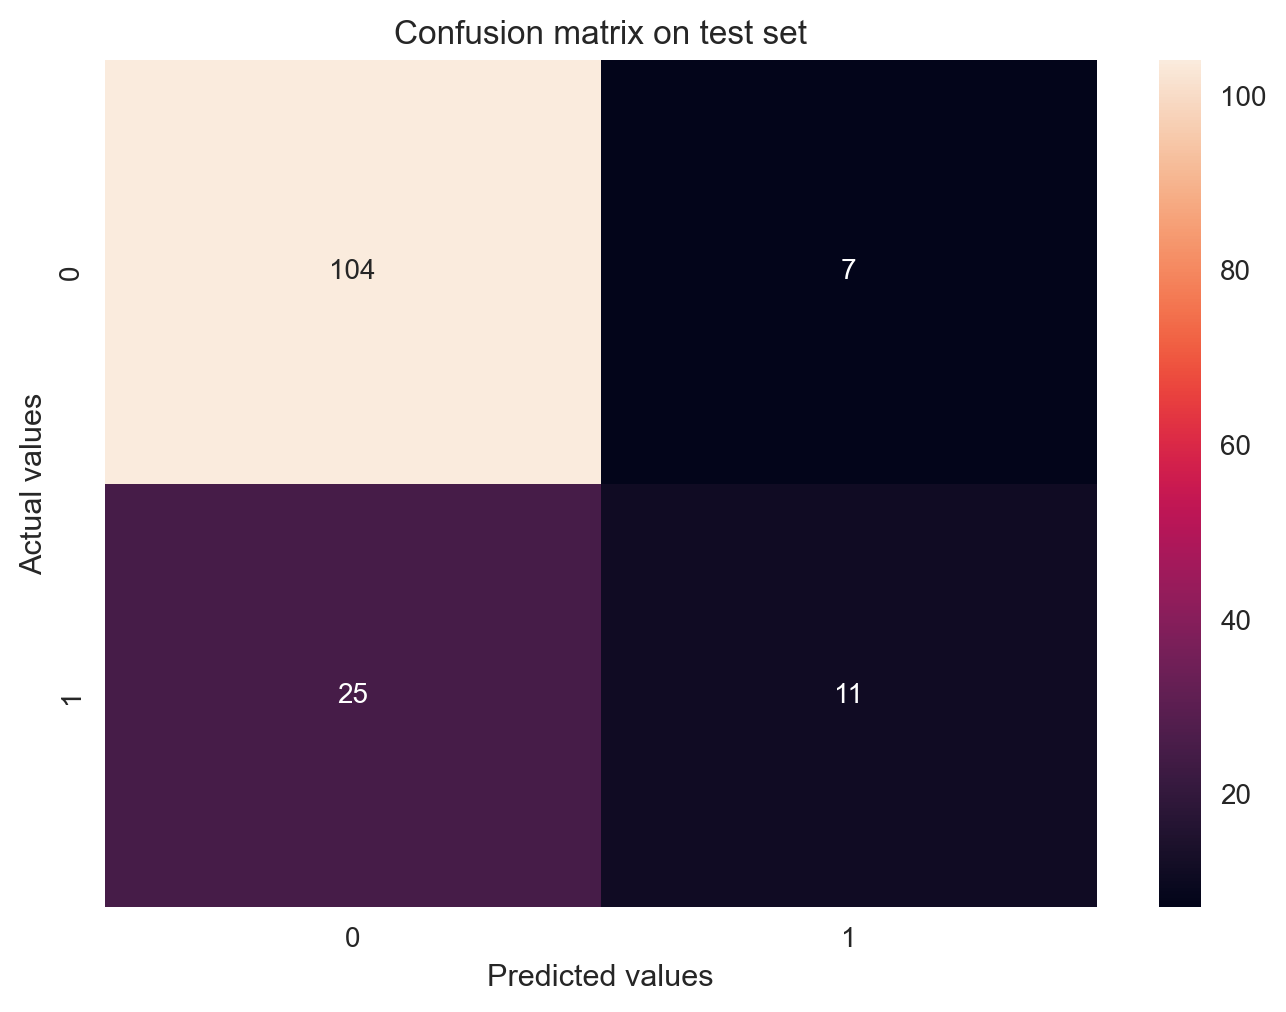

In [63]:
# confusion matrix  heatmap (Reference:[7])
cf_matrix = metrics.confusion_matrix(t_test, t_pred_rf)
ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
ax.set(xlabel='Predicted values', ylabel='Actual values')
ax.set_title("Confusion matrix on test set")
plt.show()

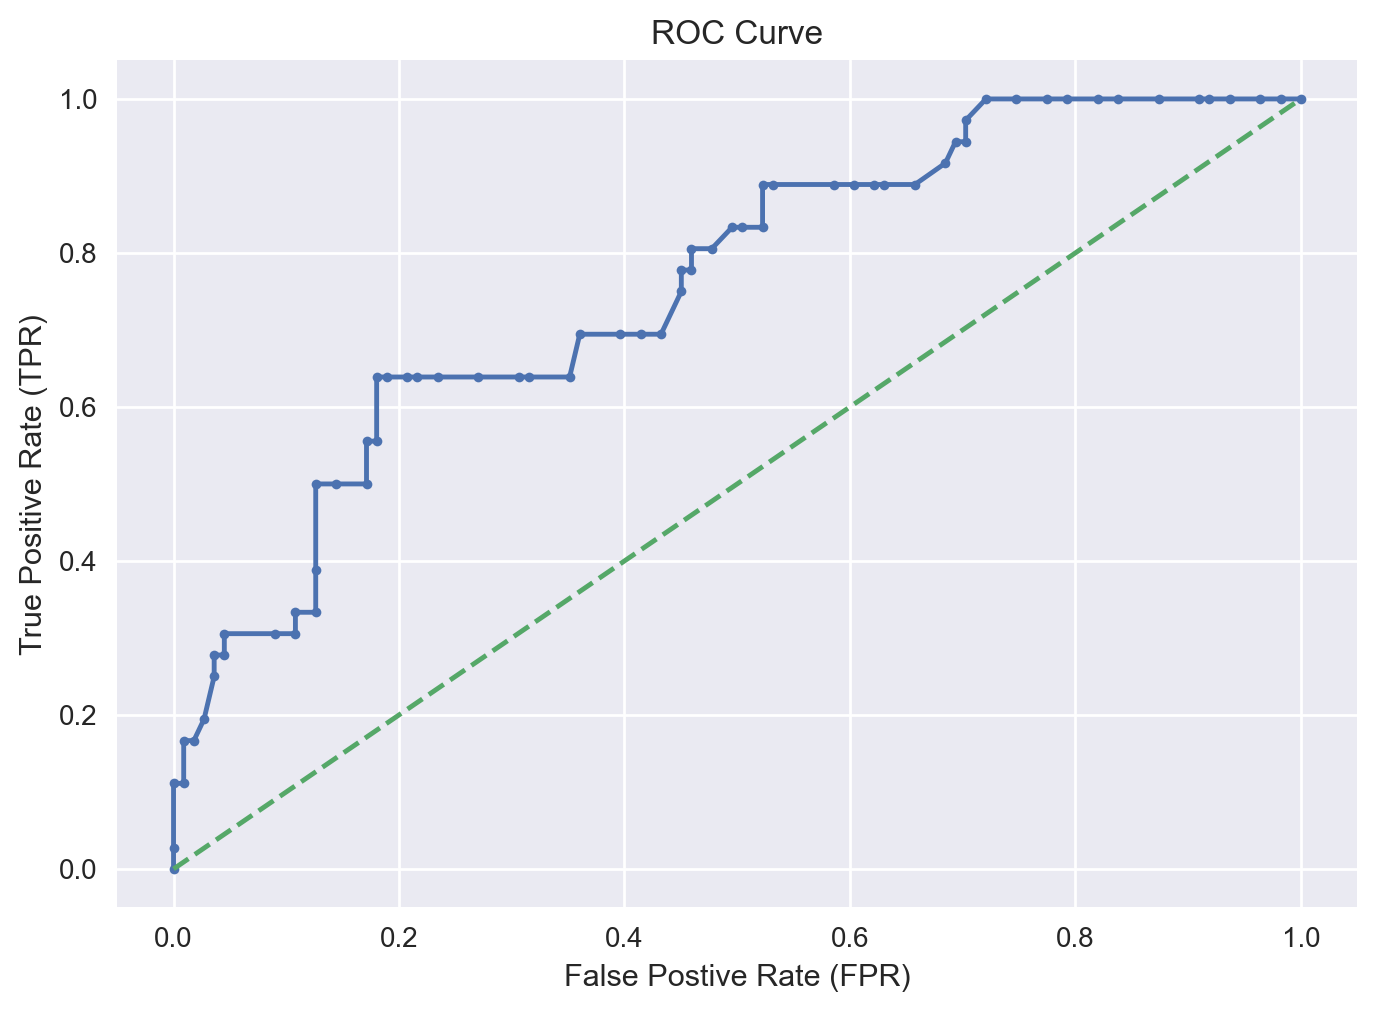

In [64]:
# ROC curve by calculating prediction scores using the predict_proba method in Scikit-learn (Reference:[7])
t_prob_rf = rf_classifier.predict_proba(D_test)
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob_rf[:, 1])
df_roc_rf = pd.DataFrame({'fpr': fpr, 'tpr': tpr})

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")
    
ax = df_roc_rf.plot.line(x='fpr', y='tpr', title='ROC Curve', legend=False, marker = '.')
plt.plot([0, 1], [0, 1], '--')
ax.set_xlabel("False Postive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
plt.show();

The ROC curve doesn't have a clear "elbow" point and the TPR points were comparatively lower than the other 2 models. This indicates the optimized Random Forest model did not have as well predictive performance as ther other 2 models.

## Neural Network Model Fitting & Tuning <a id='nn-model-fitting'></a>
PyTorch from the Python library was used to build the Neural Network.

In [65]:
#!pip install torch
#!pip install torcheval

In [66]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

Data are transformed from NumPy to PyTorch tensor format to feed the data loader in the later stage.

In [67]:
# Create the data loaders for batching and shuffling the data (Reference:[6])
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

The training data are passed to the data loader to shuffle in batch.

In [68]:
# Use PyTorch DataLoader for batching and shuffling the data (Reference:[6])
batch_size = 10
train_dataset = D_train
test_dataset = t_train

t_train_numpy = t_train.to_numpy()
traindata = Data(D_train, t_train_numpy)
trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True)

The neural networks are created with an init and a forward Python function. The init function is the initializer that defines the number of layers.  The forward function is the context of the module that specifies input data flows through the network layer with the PyTorch liner model, nn.Linear. The PyTorch sigmoid function was used to output the value between 0 and 1.  The nn.Module is the base class for all neural network modules in PyTorch. It automatically tracks and manages the model's learnable parameters (e.g., weights and biases). 

In [69]:
# Set neural network classifier parameters  (Reference:[6])
input_dim = 5
hidden_layers = 10
output_dim = 5

class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_layers)
    self.linear2 = nn.Linear(hidden_layers, output_dim)
  def forward(self, x):
    x = torch.sigmoid(self.linear1(x))
    x = self.linear2(x)
    return x

In [70]:
# Initilize and print the neural network classifier (Reference:[6])
clf_nn = Network()
print(clf_nn.parameters)

<bound method Module.parameters of Network(
  (linear1): Linear(in_features=5, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=5, bias=True)
)>


The model used CrossEntropyLoss as the loss function. CrossEntropyLoss, also known as log loss or softmax loss, computes the negative log-likelihood loss between the predicted probabilities and the target labels. This loss function is good for mutually exclusive output labels.

The model used stochastic gradient descent as the optimizer function.  The stochastic gradient descent optimizer aims to identify the optimal model parameters through training to minimize the loss function and to provide maximum accuracy in modeling. Rather than utilizing the entire dataset, a single random training batch is used to compute the gradient and adjust the model parameters.

In [71]:
# Define our loss function, the optimizer, and the learning rate (Reference:[6])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf_nn.parameters(), lr=0.1)

An epoch is a complete iteration in which the model processes all batches and updates its parameters in accordance with the calculated loss. Increasing the number of epochs can enhance model performance as it grants the model additional opportunities to learn the data pattern through each iteration. This project started with 5 epochs of run to up to 20 epochs of run. The loss ratio has been improved when the number of epochs increased. Referring to the Loss vs Epochs charts, it show the optimal number of epochs points is at around 3 epochs. There is no economic benefit to further increasing the epochs run beyond 3 epochs because it will not yield improvements in prediction performance relative to computational costs.  The model's accuracy rate has capped at around 75.5%.

In [72]:
# Training the neural network classifier (Reference:[6])
epochs = 20
losses = []
loss_list = []
for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
    # forward propagation
    outputs = clf_nn(inputs)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())
    # backward propagation
    loss.backward()
    # optimize
    optimizer.step()
    running_loss += loss.item()
    
  # display statistics
  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/(i+1) :.5f}')
  losses.append(running_loss/(i+1))

[1,    35] loss: 0.88309
[2,    35] loss: 0.64028
[3,    35] loss: 0.60673
[4,    35] loss: 0.58872
[5,    35] loss: 0.59695
[6,    35] loss: 0.58002
[7,    35] loss: 0.56822
[8,    35] loss: 0.57247
[9,    35] loss: 0.58303
[10,    35] loss: 0.56615
[11,    35] loss: 0.58106
[12,    35] loss: 0.57956
[13,    35] loss: 0.57120
[14,    35] loss: 0.56110
[15,    35] loss: 0.57763
[16,    35] loss: 0.56205
[17,    35] loss: 0.57492
[18,    35] loss: 0.57738
[19,    35] loss: 0.57599
[20,    35] loss: 0.57607


Text(0, 0.5, 'loss')

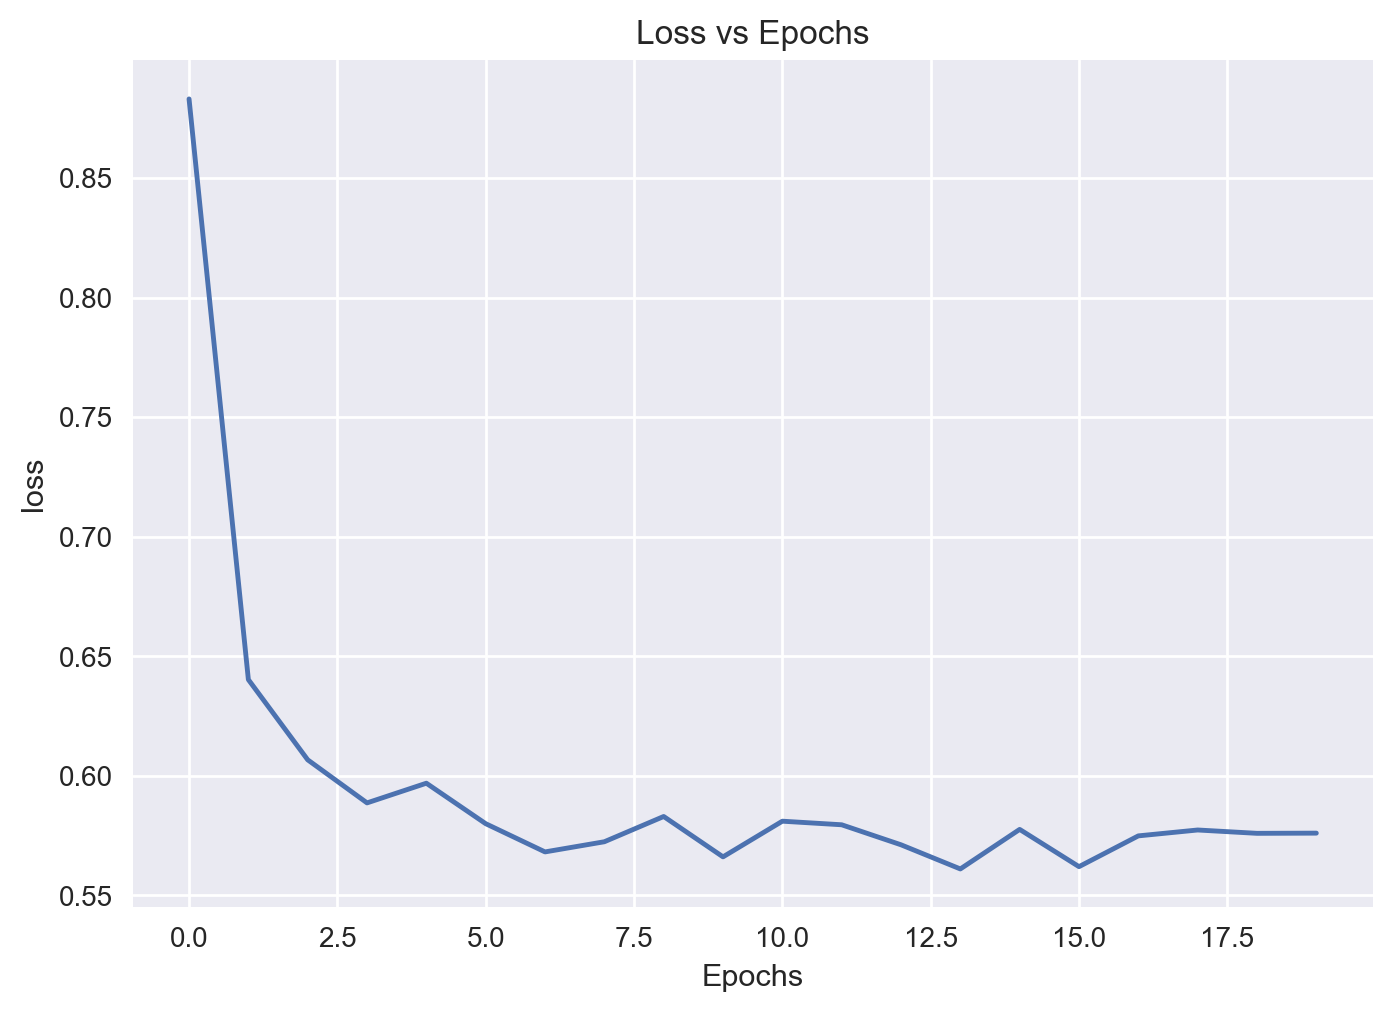

In [73]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

After model been trained, the test data are passed to the data loader to shuffle it in batch to perform prediction.

In [74]:
# Testing the trained model (Reference:[6])
t_test_numpy = t_test.to_numpy()
testdata = Data(D_test, t_test_numpy)
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=True)

Testing model accuracy was calculated using the number of correct predictions against the number of test data. Precision, recall, and F1 scores are calculated based on the True Positives (TP), False Positives (FP), and False Negatives (FN) prediction with the predicted and true label values.  This project obtained 0 in Precision, Recall, and F1 scores. The prediction results were passed to the sklearn.metrics module to recalculate Precision, Recall, and F1 scores, yielding the same outcome with 0. The roc_auc score obtained from sklearn.metrics module is 0.5, the lowest compared to other 3 non Neural Network model in this project.


In [75]:
# Model performance (Reference:[6],[8])
correct2, correct, total = 0, 0, 0
y_true = []
y_pred = []
# no need to calculate gradients during inference
with torch.no_grad():
  for data in testloader:
    inputs, labels = data
    # calculate output by running through the network
    outputs = clf_nn(inputs)
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())
    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Convert lists to tensors for calculation
y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)
# Calculating precision, recall, and F1 score using PyTorch
TP = ((y_pred_tensor == 1) & (y_true_tensor == 1)).sum().item()
FP = ((y_pred_tensor == 1) & (y_true_tensor == 0)).sum().item()
FN = ((y_pred_tensor == 0) & (y_true_tensor == 1)).sum().item()

precision = TP / (TP + FP) if TP + FP > 0 else 0
recall = TP / (TP + FN) if TP + FN > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0    

print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct / total:.2f}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy of the network on the 147 test data: 75.51%
Precision: 0
Recall: 0.0
F1 Score: 0


In [76]:
# log model performance
dict_result = { 'model':'Neural Network',
                'accuracy':round(metrics.accuracy_score(y_true, y_pred),2),
                'err_rate':round(1 - metrics.accuracy_score(y_true, y_pred),2),                
                'precision':round(metrics.precision_score(y_true, y_pred),2),
                'recall':round(metrics.recall_score(y_true, y_pred),2),
                'f1':round(metrics.f1_score(y_true, y_pred),2),
                'roc_auc':round(metrics.roc_auc_score(y_true, y_pred),2)
               }
df_result = df_result.append(dict_result, ignore_index=True)

In conclusion, the Neural Network constructed in this project did not perform well on the project problem.  The Neural Network used the liner Pytorch model with the stochastic gradient descent as the optimizer, and the cross entropy as the loss function.  Hyperparameter tuning has been performed on the number of batch sizes, number of layers, and number of epochs.  However, the model accuracy rate is lower than other non-neural network models in this project.  This may be due to the high loss rate have been experienced during training and testing.  The other reason might be the data size of this dataset is too small and not able to provide enough data for the Neural Network model to learn and adjust model weight and parameters. 

## Model Comparison <a id='model-ev'></a>

The K Nearest Neighbor (KNN), Decision Tree (DT), Random Forest (RF), and Neural Network (NN) classification models were executed with optimal hyperparameters selected via the hyperparameter tuning process.

| Model                | Hyperparameters                                                                       |
|----------------------|---------------------------------------------------------------------------------------|
| K Nearest Neighbours | Euclidean distance, 3 Neighbours                                                      |
| Decision Trees       | Entropy Information gain, 2 Max Depth, 2 Min Samples Split                            |
| Random Forests       | Entropy Information gain, 250 number of decision trees, sqrt method in   max features |
| Neural Network       | 10 batch_size, 10 hidden layers, 3 epochs                                             |

The below table summarizes the performance of the 4 models.  Out of the four methods, KNN achieved the best model performance accuracy score, precision, recall, F1, and Roc Auc scores.  Furthermore, KNN produces the best ROC curve among the three methods with the highest corresponding TPR and an "elbow" between FNR 0.6 and 0.8. This indicates the optimized KNN model has a good predictive performance compared to the DT or RT models.  Other than that, the KNN model has a faster run time when compared to the random forest model. Last but not least, the KNN model is comparatively easy to understand when compared to the Random Forest and Neural Network model.  Out of all the above reasons, this project will pick the K Nearest Neighbor due to it achieved the best model performance compared with the other 3 methods.  The other reason is this project's data size is small and the K Nearest Neighbor performance seems to be less impacted by this concern.

In [77]:
df_result

,model,accuracy,err_rate,precision,recall,f1,roc_auc
0,K Nearest Neighbor,0.79,0.21,0.79,0.79,0.79,0.72
1,Decision Tree,0.76,0.24,0.76,0.76,0.76,0.51
2,Random Forest,0.78,0.22,0.78,0.78,0.78,0.62
3,Neural Network,0.76,0.24,0.00,0.00,0.00,0.50


<AxesSubplot:xlabel='model'>

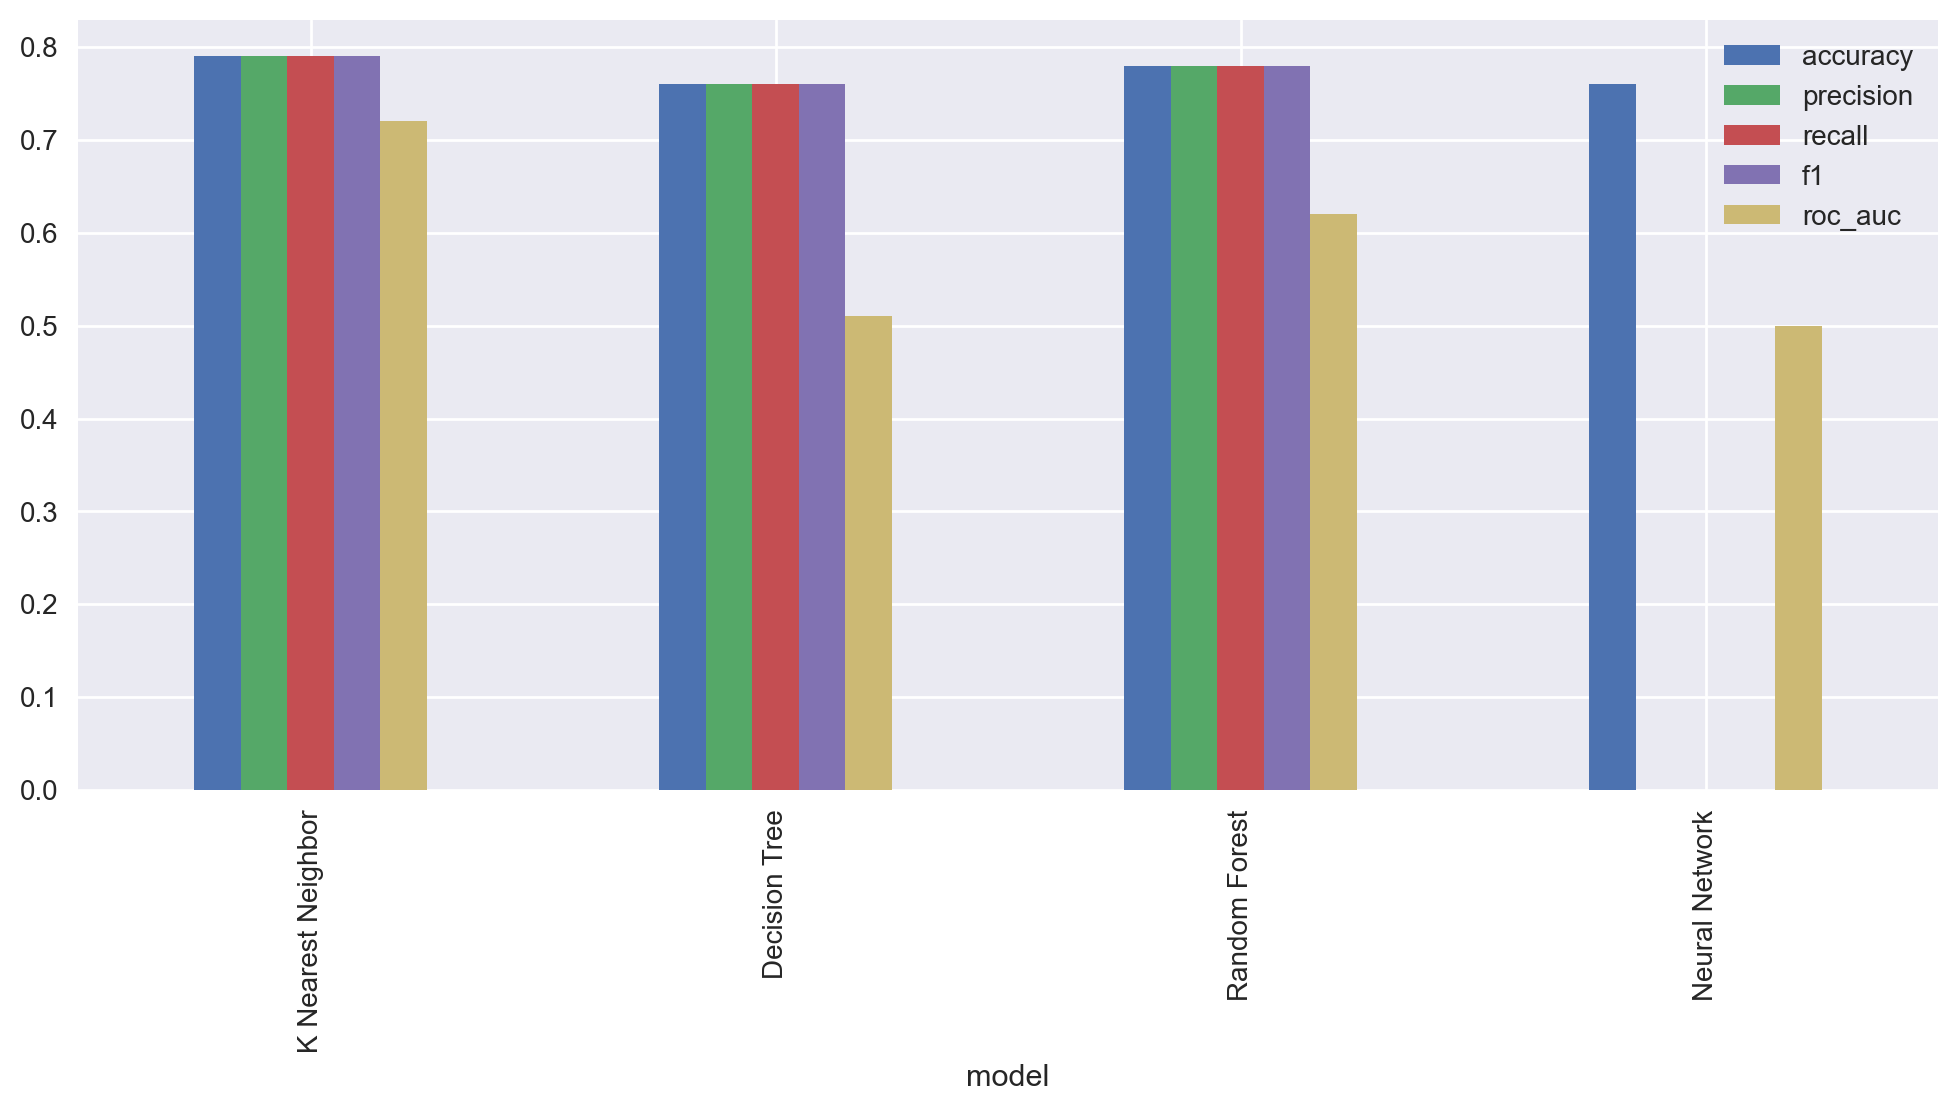

In [78]:
df_result.plot(x="model", y=["accuracy","precision", "recall","f1", "roc_auc"], kind="bar", figsize=(12, 5))

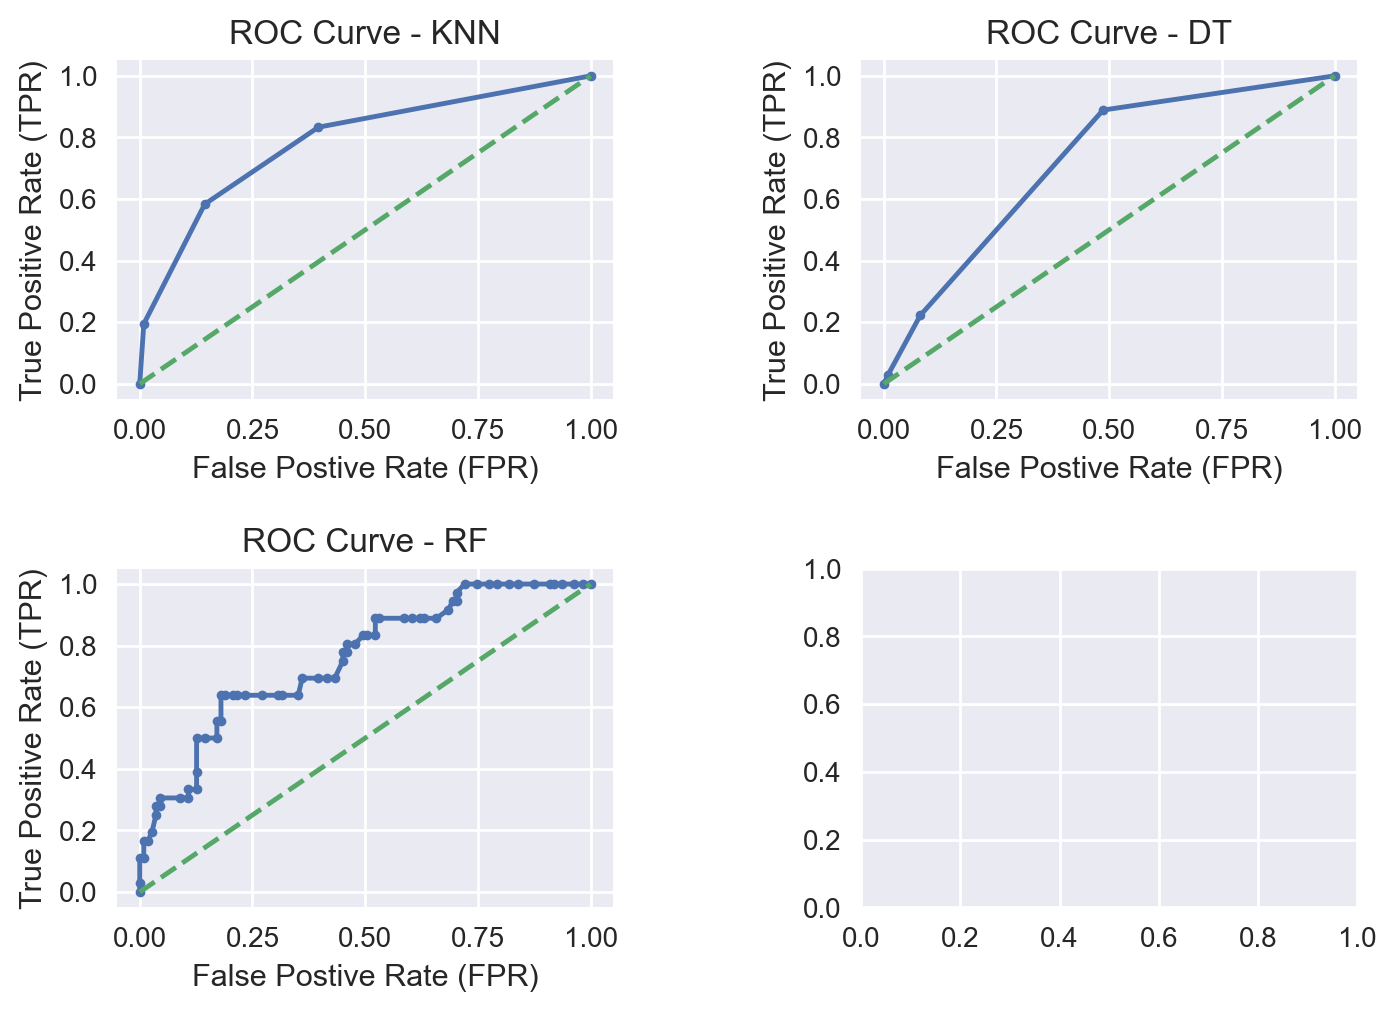

In [79]:
# ROC curve by calculating prediction scores using the predict_proba method in Scikit-learn
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

df_roc_knn.plot(x='fpr', y='tpr', kind='line', title='ROC Curve - KNN', legend=False, marker = '.', ax=ax1)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel("False Postive Rate (FPR)")
ax1.set_ylabel("True Positive Rate (TPR)")

df_roc_dt.plot(x='fpr', y='tpr', kind='line', title='ROC Curve - DT', legend=False, marker = '.', ax=ax2)
ax2.plot([0, 1], [0, 1], '--')
ax2.set_xlabel("False Postive Rate (FPR)")
ax2.set_ylabel("True Positive Rate (TPR)")

df_roc_rf.plot(x='fpr', y='tpr', kind='line', title='ROC Curve - RF', legend=False, marker = '.', ax=ax3)
ax3.plot([0, 1], [0, 1], '--')
ax3.set_xlabel("False Postive Rate (FPR)")
ax3.set_ylabel("True Positive Rate (TPR)")

plt.subplots_adjust(wspace=0.5, hspace=0.5)

## Critique & Limitations  <a id='critique-limit'></a>

Limitations:<br>

Data gathering is one of the limitations of this project.  Many sources can provide companies' fundamental data but most of them require a subscription charge.  Suppose company fundamental data are public information, however, free downloads of consolidated S&P 500 companies' fundamental data are hard to obtain.  Thus, this reason has limited the number of target features that can be obtained for this project.  

The other limitation in data gathering is to obtain a sufficient data size. The project only utilized 500 companies' YTD returns for modeling.  If more data and resources are available, more snapshots of return data, like daily or weekly, can be applied to modeling to enhance the model performance.  Insufficient sample size especially affected the performance of complex modeling like Neural Network or Random Forest, because these models require data to train for model prediction.  

Computer power is another bottleneck in this project. This issue impacts the most during the hyperparameter tuning process.  When a model has more available hyperparameters, it requires more iterations to test-run each hyperparameter combination.  Due to insufficient computer power, this project needs to cut down the number of hyperparameters in the tuning process, affecting the hyperparameter tuning performance.

Strengths:<br>

Although facing the above limitations, this project has applied a dynamic approach to eliminate the smell and imbalance dataset concerns. The approach includes the use of spFSR and n-fold cross-validation in feature selection, the use of the Roc curve in model evaluation, and the use of micro average in model performance comparison.

In data selection, this project has selected the companies from the S&P 500 index which contains the 500 leading publicly traded companies in the United States providing a generalized companies dataset for modeling.

## Summary and Conclusions <a id='Summary-and-Conclusion'></a>

### Project Summary <a id='proj-summary'></a>

The goal of this project is to apply a machine learning model to predict profit or loss for stock return with companies' fundamental or economic data.  In data selection, this project has used the companies from the S&P 500 index to ensure the dataset is generalized.  The S&P 500 index contains the 500 leading publicly traded companies in the United States. The year-to-date return of each company was used as the target value of this project.  Positive and negative returns are defined as the binary target values. This project has selected 9 descriptive features for modeling, they are exchange, sector, industry, market capitalization, EBITDA, revenue growth, state, country, and the number of full-time employees. 

In the data preprocessing stage, companies with returns above 100% have been considered outliers and removed from modeling. Missing values had been filled back manually or replaced with appropriate values. Next, encoding was applied to features and target values. Due to the nature of this dataset, a nominal encoding method was used. To understand the data pattern, several visualization charts have been plotted.  On top of that the MinMaxScaler method was employed to normalize the dataset, ensuring that each descriptive feature falls within the range of 0 to 1.

Next, feature selection using F-Score, Random Forest Feature, and spFSR feature importance score has been performed. With comprehensive evaluation, the 5 highest scores feature from spFSR had been shortlisted, they are 'Sector', 'Industry', 'EBITDA', 'Revenue Growth', and 'Market Cap'.  

To fulfill the project's objective of utilizing fundamental or economic data for predicting stock returns, this project employed classification machine learning models. To ensure a thorough assessment, experiments with several classification algorithms including K Nearest Neighbor (KNN), Decision Tree (DT), Random Forest (RT), and Neural Network (NN), have been performed.  

To fit the model, the dataset was split into 70% for training and 30% for testing purposes.  The hyperparameters tuning process was conducted using the stratified 5-fold cross-validation and the grid search with an accuracy scoring method.  The hyperparameters tuning process helps define the optimal hyperparameters setting.

After that, model accuracy, precision, recall, f1, and roc auc score metrics were used as metrics to compare the performance between the 4 models.

### Summary of Findings <a id='summary-findings'></a>

With experiments on four classification algorithms, this project found the K Nearest Neighbor (KNN) algorithms performed the best in predicting profit or loss for stock return with companies' fundamental or economic data for small data size problems. The K Nearest Neighbor (KNN) algorithms attained an accuracy, precision, recall, and F1 score of 79% in this project's problem. 

Through feature selection on F-Score, Random Forest Feature, and spFSR feature importance score, this project has shortlisted 5 optimal features out of 9 descriptive features for modeling.  The 5 optimal features are 'Sector', 'Industry', 'EBITDA', 'Revenue Growth', and 'Market Cap'.  Other than modeling, the feature selection process helps pinpoint what economic or company fundamental data users should look into.  In addition, when compared to using the full set of descriptive features for modeling, the 5 optimal features achieved higher performance accuracy and faster model process time.      

The performance of the four classification algorithms in this project problem is highly comparable. The accuracy scores range from 76% to 79%. Similarly, the precision, recall, and F1 scores of the three models also fall within the 76% to 79% range.  The differentiation between models lies in the ROC AUC score and the shape of the ROC curve that the K Nearest Neighbor (KNN) algorithms have 72% and better ROC curve outperformed the result of the other 3 models.

Last but not least, the K Nearest Neighbor (KNN) algorithm is simple and easy to understand. It works well with small to medium-sized datasets suited to this project's targeted general investment users.

### Conclusions <a id='conclusions'></a>

Predicting stock movement is a complex task.  General investors often rely solely on historical prices for regression prediction, neglecting the significant impact of fundamental and economic variables on price movement.  One reason for this phenomenon could be the complexity of predicting the stock movement with the multitude of fundamental and economic variables.  Machine learning processes can effectively solve this issue for general investors.

Overall, the model this project results shows good model performance including accuracy, 
precision, and recall. The accuracy, precision, recall, and F1 score all achieved 79% in predicting the possibility of a stock’s price movement. Many other factors that can influence the price movement are not included in this modeling exercise, like market sentiment, political situation... etc. This project achieved an accuracy rate of 79% indicating a robust prediction.

Furthermore, when specialized in profit return prediction, the KNN algorithm achieved 86% in accuracy, precision, recall, and F1 score outperformed the loss return prediction. Typically, general investors are more inclined to analyze which stocks can generate profits and this project's result achieved robust prediction in this area.  

## References

[1] Dr. Devindri P(2024). SK Part 2: Feature Selection and Ranking (Week 7 Lectorial Sample). RMIT - Machine Learning (MATH2319). Retrieved May 1, 2024 from https://rmit.instructure.com/courses/124255/files/37318277?module_item_id=6138333

[2] Dr. Devindri P(2024). Data Preprocessing Exercises (Week 5 Lectorial Sample). RMIT - Machine Learning (MATH2319). Retrieved May 1, 2024 from https://rmit.instructure.com/courses/124255/files/34425561?module_item_id=5634631

[3] Gianluca M (2021). Feature selection with Random Forest.  Your Data Teacher. Retrieved May 1, 2024 from https://www.yourdatateacher.com/2021/10/11/feature-selection-with-random-forest/

[4] David A, Milad M, Zeren Y, Anders Y, Niranjan A, Yong W, Babak A, Alev G (2023). k-best feature selection and ranking via stochastic approximation.  Science Direct.  Retrieved May 1, 2024 from https://www.sciencedirect.com/science/article/abs/pii/S0957417422018826

[5] Jeril K (2022). A Simple Neural Network Classifier using PyTorch, from Scratch. Medium. Retrieved May 6, 2024 from https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2

[6] Gianluca M (2021). Feature selection with Random Forest.  Your Data Teacher. Retrieved May 1, 2024 from https://www.yourdatateacher.com/2021/10/11/feature-selection-with-random-forest/

[7] Dr. Devindri P(2024). Practice Exercise: Scikit-Learn 3. RMIT - Machine Learning (MATH2319). Retrieved May 6, 2024 from https://rmit.instructure.com/courses/124255/files/36636982?module_item_id=6037114

[8] Geeks for Geeks (2024). How to calculate the F1 score and other custom metrics in PyTorch?. Retrieved May 7, 2024 from 
https://www.geeksforgeeks.org/how-to-calculate-the-f1-score-and-other-custom-metrics-in-pytorch/

[9] Shittu A (2024). What is cross-entropy loss in PyTorch?. Educative. Retrieved May 7, 2024 from https://www.educative.io/answers/what-is-cross-entropy-loss-in-pytorch

[10] Geeks for Geeks (2024). ML | Stochastic Gradient Descent (SGD). Retrieved May 7, 2024 from 
https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/

[11] De Jun H (2021). Learning Day 22: What is nn.Module in Pytorch. Medium. Retrieved May 8, 2024 from 
https://medium.com/dejunhuang/learning-day-22-what-is-nn-module-in-pytorch-ecf8400f411a

[12] Geeks for Geeks (2024). Epoch in Machine Learning. Retrieved May 8, 2024 from https://www.geeksforgeeks.org/epoch-in-machine-learning/